In [1]:
#setup libraries & data
#notebook for additional EDA as models are trained

#import pandas library for data analysis & manipulation
import pandas as pd
#import zipfile library to support reading zipped file into pandas dataframe
import zipfile
#import numpy library for scientific computing
import numpy as np
#import datetime library to work with time series data
import datetime as dt
#import seaborn & matplotlib libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
#for publishing graphs inside jupyter notebooks
%matplotlib inline
#import statsmodel library for statisical models & analysis
import statsmodels.api as sm

#set file path names for data sources, Kaggle prediction competition provides seven sources 
#https://www.kaggle.com/competitions/store-sales-time-series-forecasting 

#training data for model
train_path = "***\\Project_Data\\train.csv.zip"
#daily volume of transactions per store
trans_path = "***\\Project_Data\\transactions.csv.zip"
#holiday schedule
holiday_path = "***\\Project_Data\\holidays.csv"
#daily oil prices
oil_path = "***\\Project_Data\\oil.csv"
#store location & type
stores_path = "***\\Project_Data\\stores.csv"
#test data for prediction model
test_path = "***\\Project_Data\\test.csv"
#sample format for submitting prediction to Kaggle
sample_path = "***\\Project_Data\\sample_submission.csv"

#import data into pandas dataframe
train_data = pd.read_csv(train_path,compression="zip")
trans_data = pd.read_csv(trans_path,compression="zip")
holiday_data = pd.read_csv(holiday_path)
oil_data = pd.read_csv(oil_path)
stores_data = pd.read_csv(stores_path)
test_data = pd.read_csv(test_path)
sample_data = pd.read_csv(sample_path)
                            
#check number of rows & columns in each set
print("training set",train_data.shape)
print("store transactions", trans_data.shape)
print("holiday calendar", holiday_data.shape)
print("daily oil prices", oil_data.shape)
print("store locations & types", stores_data.shape)
print("testing set", test_data.shape)
print("sample submission", sample_data.shape)


training set (3000888, 6)
store transactions (83488, 3)
holiday calendar (350, 6)
daily oil prices (1218, 2)
store locations & types (54, 5)
testing set (28512, 5)
sample submission (28512, 2)


In [2]:
#additional exploration as we train models

In [3]:
#prep training data
train_data = train_data.drop(['id'],axis=1)
train_data["date"] = pd.to_datetime(train_data["date"],errors='coerce')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 114.5+ MB


In [4]:
#prep training data
test_data["date"] = pd.to_datetime(test_data["date"],errors='coerce')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [5]:
#review date range of train & test date
print("training set date range:", train_data["date"].min(), " to ", train_data["date"].max())
print("testing set date range:", test_data["date"].min(), " to ", test_data["date"].max())

training set date range: 2013-01-01 00:00:00  to  2017-08-15 00:00:00
testing set date range: 2017-08-16 00:00:00  to  2017-08-31 00:00:00


In [6]:
#we spent time checking out holidays
#but for purposes of the competition, only the prediction date range matters

In [7]:
holiday_data["date"] = pd.to_datetime(holiday_data["date"],errors='coerce')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [8]:
holiday_test = holiday_data.loc[(holiday_data["date"] >= "2017-07-16") & (holiday_data["date"] < "2017-09-01")]
holiday_test

date        type    locale locale_name  \
320 2017-07-23     Holiday     Local     Cayambe   
321 2017-07-24  Additional     Local   Guayaquil   
322 2017-07-25  Additional     Local   Guayaquil   
323 2017-08-05     Holiday     Local  Esmeraldas   
324 2017-08-10     Holiday  National     Ecuador   
325 2017-08-11    Transfer  National     Ecuador   
326 2017-08-15     Holiday     Local    Riobamba   
327 2017-08-24     Holiday     Local      Ambato   

                                description  transferred  
320                Cantonizacion de Cayambe        False  
321                Fundacion de Guayaquil-1        False  
322                  Fundacion de Guayaquil        False  
323                 Fundacion de Esmeraldas        False  
324           Primer Grito de Independencia         True  
325  Traslado Primer Grito de Independencia        False  
326                   Fundacion de Riobamba        False  
327                     Fundacion de Ambato        False

In [9]:
holiday_ambato = holiday_data.loc[holiday_data["locale_name"] == "Ambato"]
holiday_ambato

date     type locale locale_name              description  \
16  2012-08-24  Holiday  Local      Ambato      Fundacion de Ambato   
27  2012-11-12  Holiday  Local      Ambato  Independencia de Ambato   
69  2013-08-24  Holiday  Local      Ambato      Fundacion de Ambato   
80  2013-11-12  Holiday  Local      Ambato  Independencia de Ambato   
132 2014-08-24  Holiday  Local      Ambato      Fundacion de Ambato   
143 2014-11-12  Holiday  Local      Ambato  Independencia de Ambato   
187 2015-08-24  Holiday  Local      Ambato      Fundacion de Ambato   
197 2015-11-12  Holiday  Local      Ambato  Independencia de Ambato   
271 2016-08-24  Holiday  Local      Ambato      Fundacion de Ambato   
282 2016-11-12  Holiday  Local      Ambato  Independencia de Ambato   
327 2017-08-24  Holiday  Local      Ambato      Fundacion de Ambato   
338 2017-11-12  Holiday  Local      Ambato  Independencia de Ambato   

     transferred  
16         False  
27         False  
69         False  
80         False  
132        False  
143        False  
187        False  
197        False  
271        False  
282        False  
327        False  
338        False

In [10]:
#an important event missing from calendar: https://dmcecuador.com/fruit-and-flowers-festival

In [11]:
#as i dive into forecasting process
#i recall early EDA revealed not all stores were the same age
#this could be relevant
date_min = pd.DataFrame(trans_data.groupby("store_nbr").date.min())
date_min = date_min.sort_values(by="date", ascending=False)
date_min

date
store_nbr            
52         2017-04-20
22         2015-10-09
42         2015-08-21
21         2015-07-24
29         2015-03-20
20         2015-02-13
53         2014-05-29
36         2013-05-09
39         2013-01-02
31         2013-01-02
32         2013-01-02
33         2013-01-02
34         2013-01-02
35         2013-01-02
37         2013-01-02
38         2013-01-02
1          2013-01-02
40         2013-01-02
30         2013-01-02
43         2013-01-02
44         2013-01-02
45         2013-01-02
46         2013-01-02
47         2013-01-02
48         2013-01-02
49         2013-01-02
50         2013-01-02
51         2013-01-02
41         2013-01-02
28         2013-01-02
2          2013-01-02
27         2013-01-02
3          2013-01-02
4          2013-01-02
5          2013-01-02
6          2013-01-02
7          2013-01-02
8          2013-01-02
9          2013-01-02
10         2013-01-02
11         2013-01-02
12         2013-01-02
13         2013-01-02
14         2013-01-02
15         2013-01-02
16         2013-01-02
17         2013-01-02
18         2013-01-02
19         2013-01-02
23         2013-01-02
24         2013-01-02
26         2013-01-02
54         2013-01-02
25         2013-01-01

In [12]:
store_sales = pd.DataFrame(train_data.groupby(["store_nbr", "date"]).sales.sum())
store_sales

sales
store_nbr date                    
1         2013-01-01      0.000000
          2013-01-02   7417.148000
          2013-01-03   5873.244001
          2013-01-04   5919.879001
          2013-01-05   6318.785010
...                            ...
54        2017-08-11   8513.834000
          2017-08-12   9139.678002
          2017-08-13  14246.827996
          2017-08-14  11882.994000
          2017-08-15  12666.858000

[90936 rows x 1 columns]

In [13]:
train52 = train_data.loc[(train_data.store_nbr == 52)]
train52

date  store_nbr                      family     sales  \
1551    2013-01-01         52                  AUTOMOTIVE     0.000   
1552    2013-01-01         52                   BABY CARE     0.000   
1553    2013-01-01         52                      BEAUTY     0.000   
1554    2013-01-01         52                   BEVERAGES     0.000   
1555    2013-01-01         52                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3000685 2017-08-15         52                     POULTRY   397.340   
3000686 2017-08-15         52              PREPARED FOODS   104.418   
3000687 2017-08-15         52                     PRODUCE  3803.368   
3000688 2017-08-15         52  SCHOOL AND OFFICE SUPPLIES    17.000   
3000689 2017-08-15         52                     SEAFOOD     7.000   

         onpromotion  
1551               0  
1552               0  
1553               0  
1554               0  
1555               0  
...              ...  
3000685            0  
3000686            0  
3000687            8  
3000688            0  
3000689            0  

[55572 rows x 5 columns]

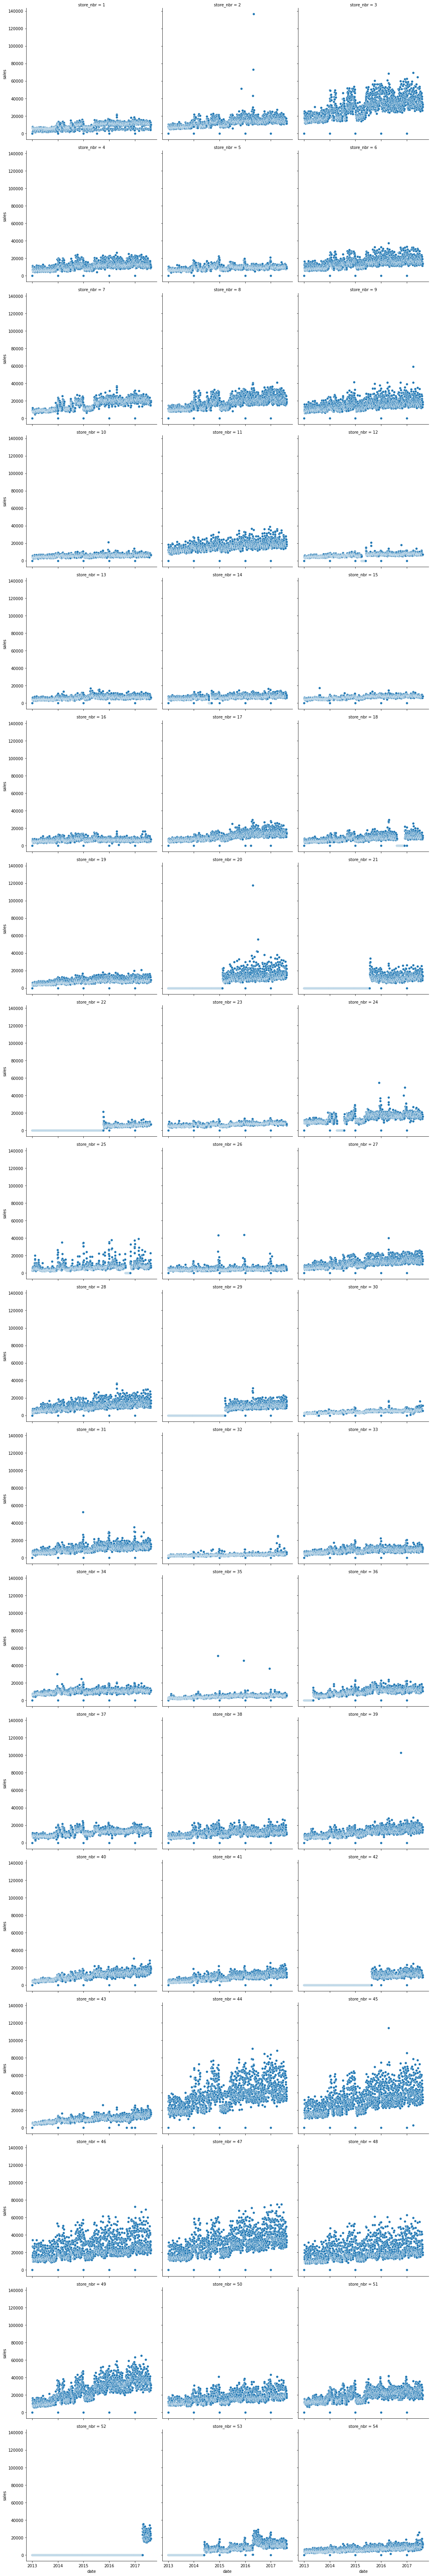

In [14]:
sns.relplot(data = store_sales, x="date", y="sales", col="store_nbr", col_wrap=3)

In [15]:
sales_plus = pd.merge(train_data, stores_data, on="store_nbr")
sales_plus

date  store_nbr                      family     sales  \
0       2013-01-01          1                  AUTOMOTIVE     0.000   
1       2013-01-01          1                   BABY CARE     0.000   
2       2013-01-01          1                      BEAUTY     0.000   
3       2013-01-01          1                   BEVERAGES     0.000   
4       2013-01-01          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3000883 2017-08-15          9                     POULTRY   438.133   
3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion   city      state type  cluster  
0                  0  Quito  Pichincha    D       13  
1                  0  Quito  Pichincha    D       13  
2                  0  Quito  Pichincha    D       13  
3                  0  Quito  Pichincha    D       13  
4                  0  Quito  Pichincha    D       13  
...              ...    ...        ...  ...      ...  
3000883            0  Quito  Pichincha    B        6  
3000884            1  Quito  Pichincha    B        6  
3000885          148  Quito  Pichincha    B        6  
3000886            8  Quito  Pichincha    B        6  
3000887            0  Quito  Pichincha    B        6  

[3000888 rows x 9 columns]

In [16]:
type_sales = pd.DataFrame(sales_plus.groupby(["type", "date"]).sales.sum())
type_sales

sales
type date                     
A    2013-01-01       0.000000
     2013-01-02  179812.730950
     2013-01-03  118412.986055
     2013-01-04  128948.202091
     2013-01-05  182073.303059
...                        ...
E    2017-08-11   59201.871010
     2017-08-12   59690.129000
     2017-08-13   74205.595000
     2017-08-14   52245.440010
     2017-08-15   62894.039000

[8420 rows x 1 columns]

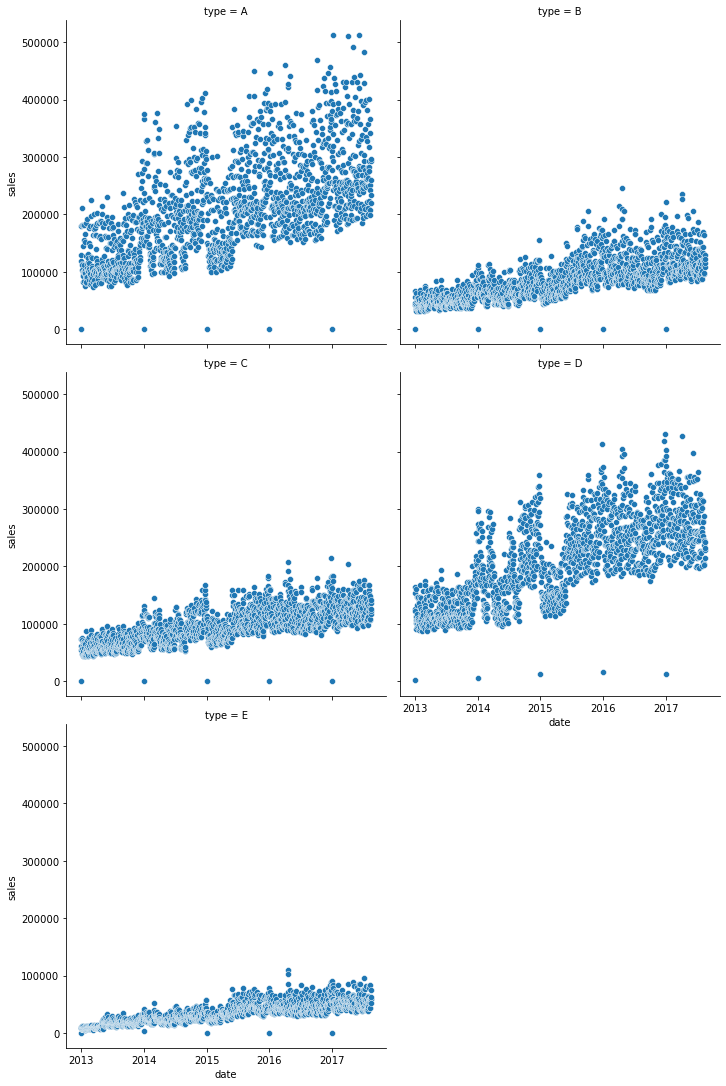

In [17]:
sns.relplot(data = type_sales, x="date", y="sales", col="type", col_wrap=2)

In [18]:
cluster_sales = pd.DataFrame(sales_plus.groupby(["cluster", "date"]).sales.sum())
cluster_sales

sales
cluster date                    
1       2013-01-01   2511.618999
        2013-01-02  23542.623996
        2013-01-03  18916.720018
        2013-01-04  19490.300999
        2013-01-05  24581.042040
...                          ...
17      2017-08-11  26070.018000
        2017-08-12  19532.964000
        2017-08-13  25713.284030
        2017-08-14  18932.967000
        2017-08-15  20154.559000

[28628 rows x 1 columns]

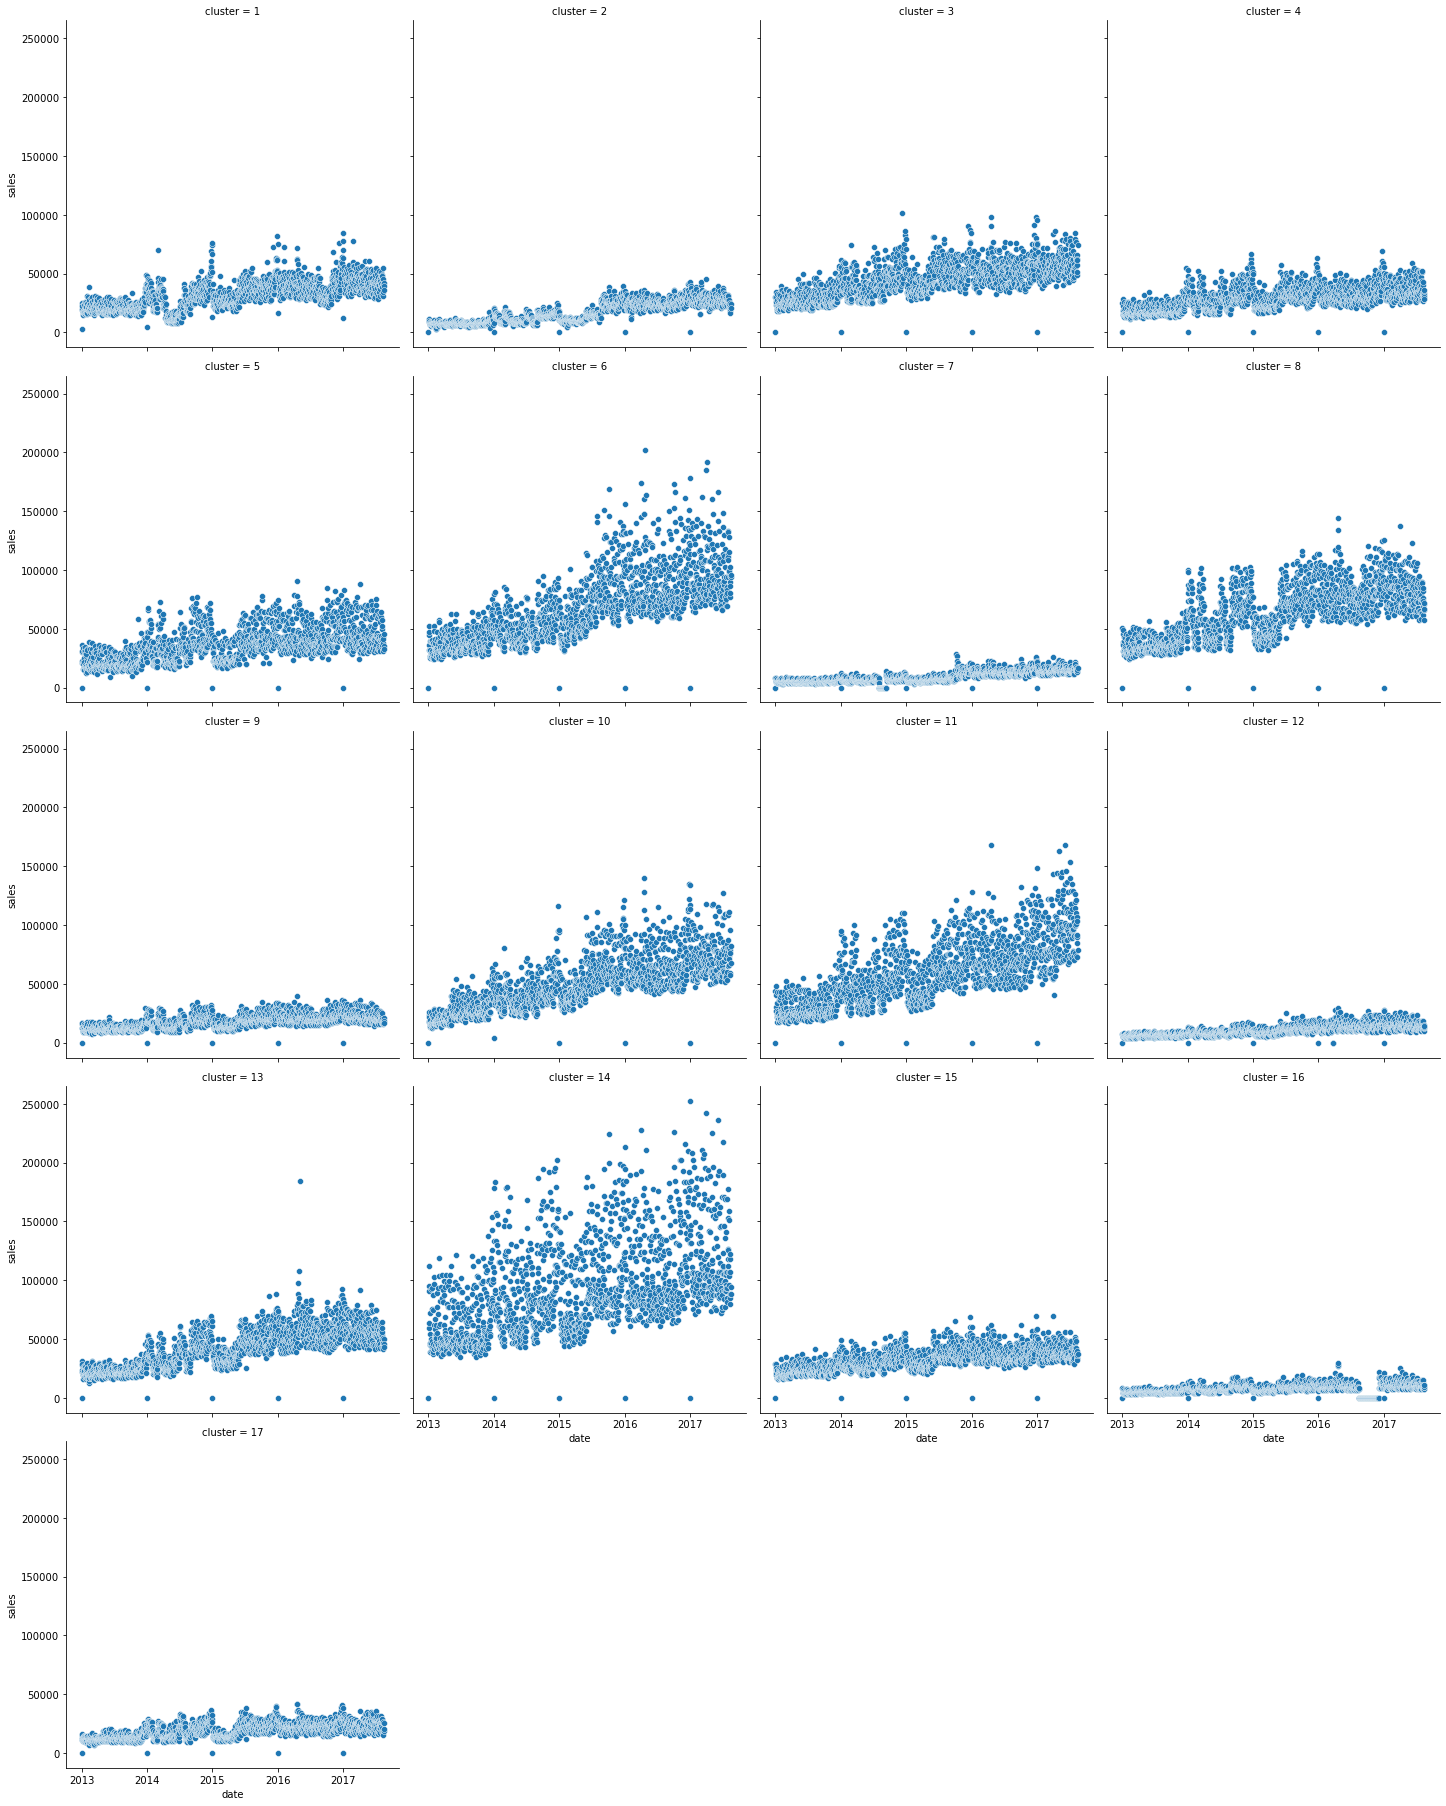

In [19]:
sns.relplot(data = cluster_sales, x="date", y="sales", col="cluster", col_wrap=4)

In [20]:
cluster_promo = pd.DataFrame(sales_plus.groupby(["cluster", "date"]).onpromotion.sum())
cluster_promo

onpromotion
cluster date                   
1       2013-01-01            0
        2013-01-02            0
        2013-01-03            0
        2013-01-04            0
        2013-01-05            0
...                         ...
17      2017-08-11          312
        2017-08-12          139
        2017-08-13          145
        2017-08-14          132
        2017-08-15          127

[28628 rows x 1 columns]

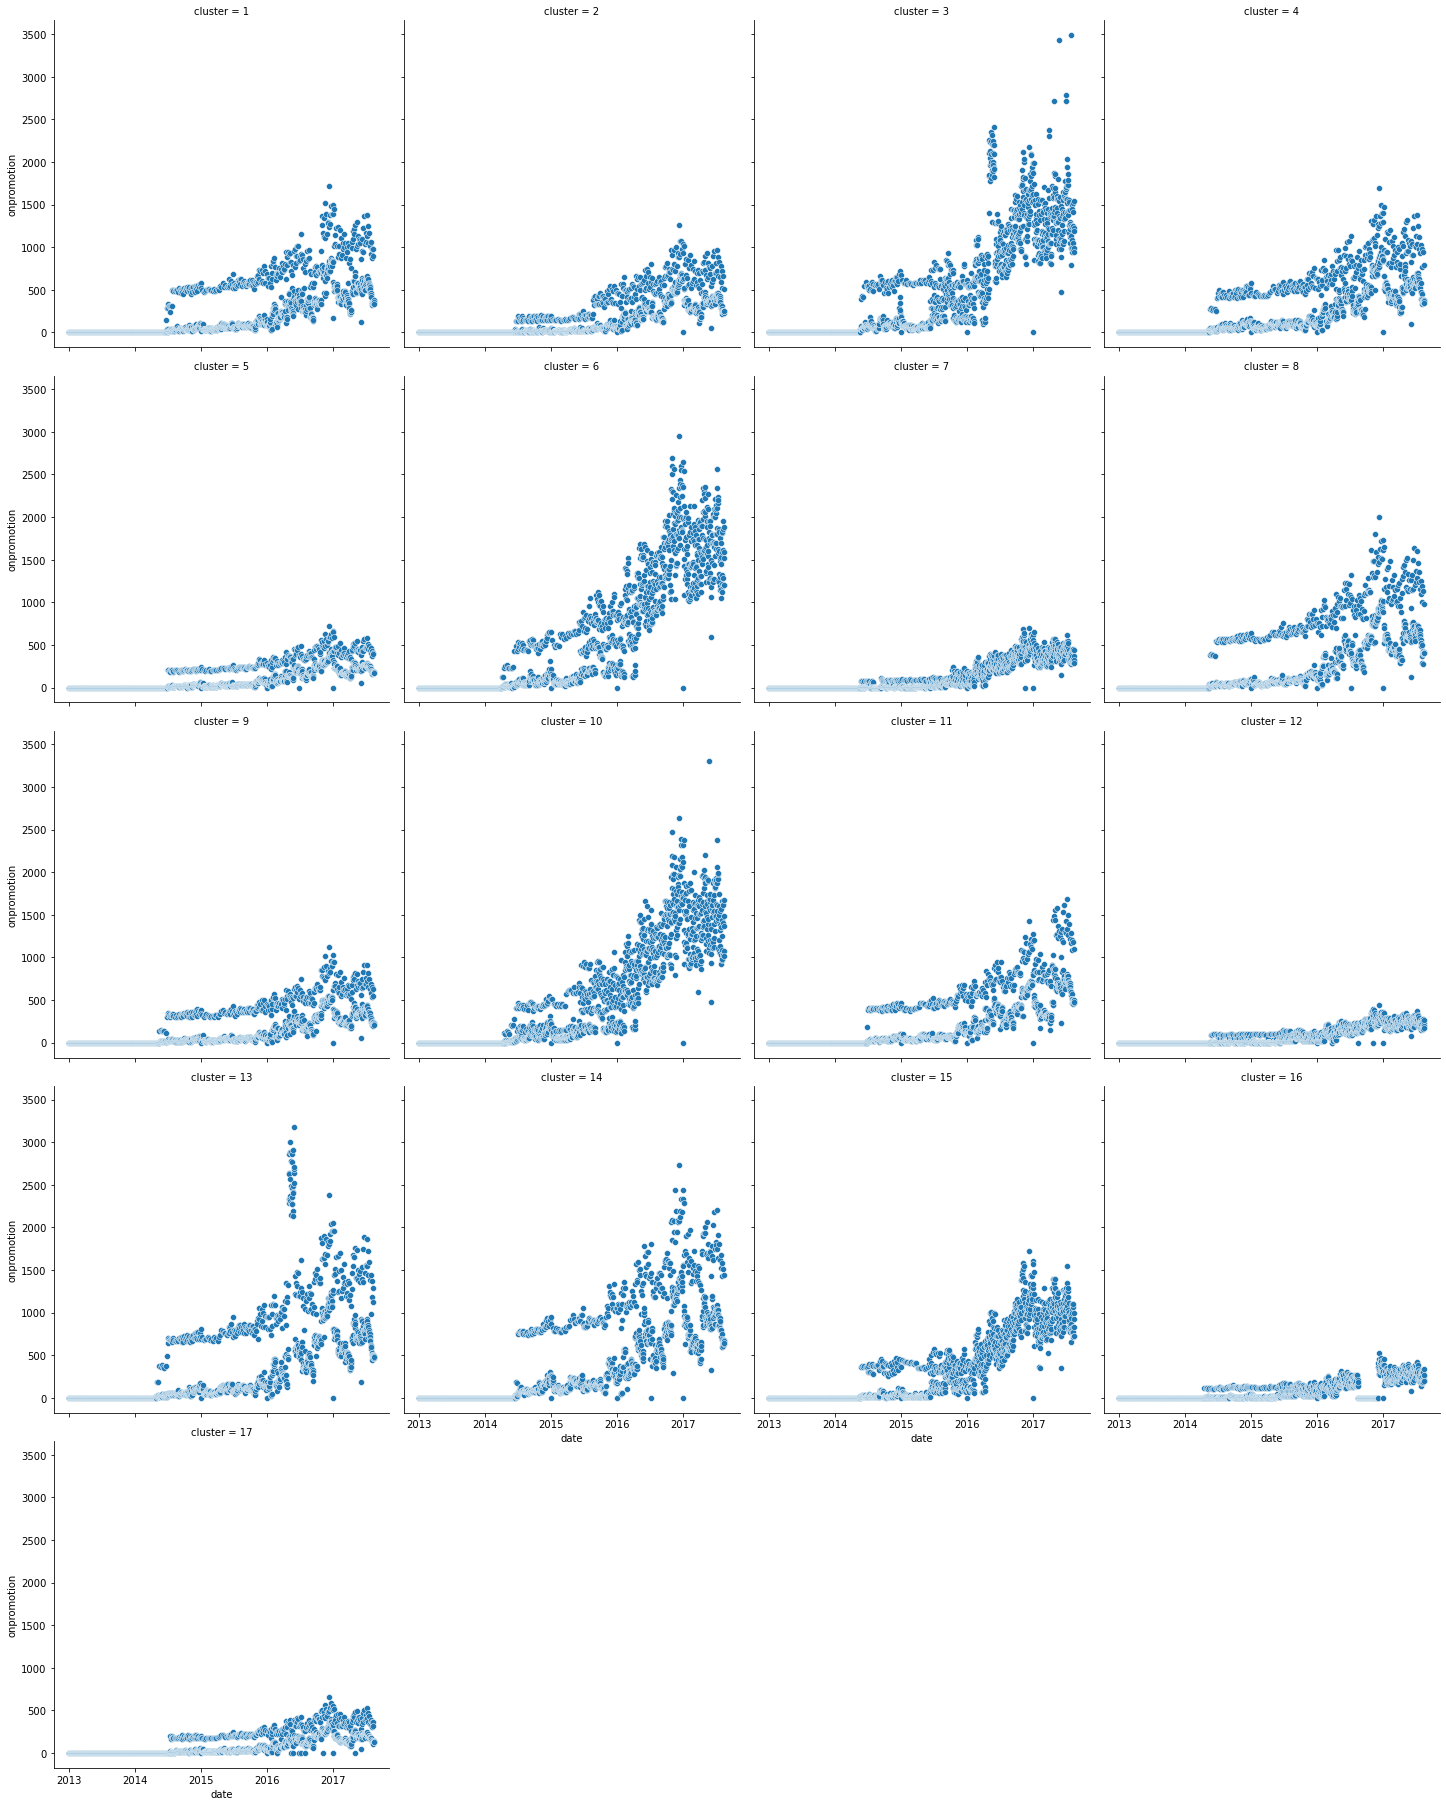

In [21]:
sns.relplot(data = cluster_promo, x="date", y="onpromotion", col="cluster", col_wrap=4)

In [22]:
cluster_promo = pd.DataFrame(sales_plus.groupby(["store_nbr", "cluster","family"]).onpromotion.mean())
cluster_promo.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1782 entries, (1, 13, 'AUTOMOTIVE') to (54, 3, 'SEAFOOD')
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   onpromotion  1782 non-null   float64
dtypes: float64(1)
memory usage: 20.1+ KB


In [23]:
cluster_promo.reset_index(inplace=True)
cluster_promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   store_nbr    1782 non-null   int64  
 1   cluster      1782 non-null   int64  
 2   family       1782 non-null   object 
 3   onpromotion  1782 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 55.8+ KB


In [24]:
cluster_promo["store_nbr"] = cluster_promo["store_nbr"].astype(object)
cluster_promo["cluster"] = cluster_promo["cluster"].astype(object)
cluster_promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   store_nbr    1782 non-null   object 
 1   cluster      1782 non-null   object 
 2   family       1782 non-null   object 
 3   onpromotion  1782 non-null   float64
dtypes: float64(1), object(3)
memory usage: 55.8+ KB


In [25]:
cluster_promo

store_nbr cluster                      family  onpromotion
0            1      13                  AUTOMOTIVE     0.008314
1            1      13                   BABY CARE     0.000000
2            1      13                      BEAUTY     0.134204
3            1      13                   BEVERAGES     9.420428
4            1      13                       BOOKS     0.000000
...        ...     ...                         ...          ...
1777        54       3                     POULTRY     0.896081
1778        54       3              PREPARED FOODS     0.415677
1779        54       3                     PRODUCE     5.385986
1780        54       3  SCHOOL AND OFFICE SUPPLIES     0.164489
1781        54       3                     SEAFOOD     0.109857

[1782 rows x 4 columns]

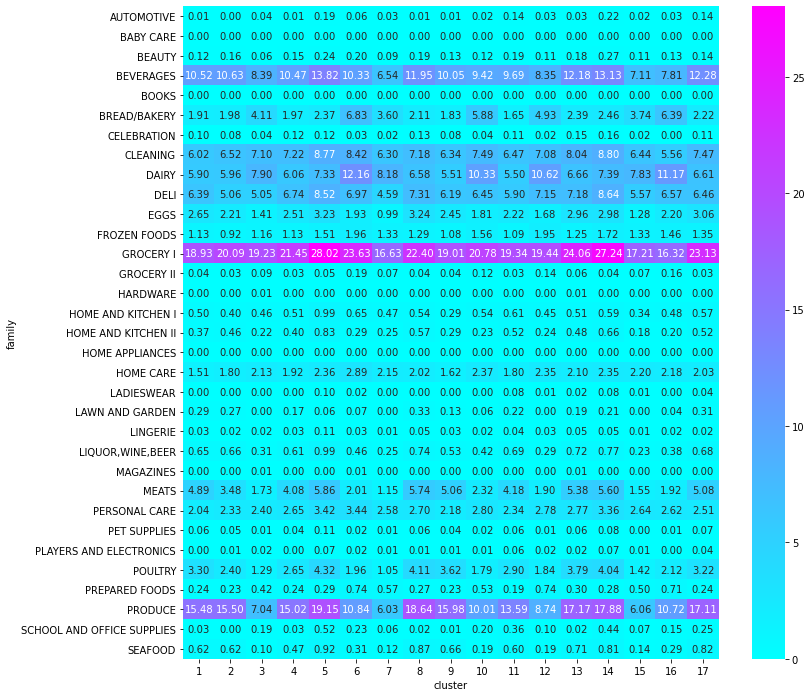

In [26]:
plt.figure(figsize=(12,12))
promo_heat = cluster_promo.pivot_table(values="onpromotion",index="family", columns="cluster",aggfunc=np.mean)
show = sns.heatmap(promo_heat, cmap="cool", annot=True, fmt=".2f")

In [27]:
type_promo = pd.DataFrame(sales_plus.groupby(["store_nbr", "type","family"]).onpromotion.mean())
type_promo.reset_index(inplace=True)
type_promo["store_nbr"] = type_promo["store_nbr"].astype(object)
type_promo["type"] = type_promo["type"].astype(object)
type_promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   store_nbr    1782 non-null   object 
 1   type         1782 non-null   object 
 2   family       1782 non-null   object 
 3   onpromotion  1782 non-null   float64
dtypes: float64(1), object(3)
memory usage: 55.8+ KB


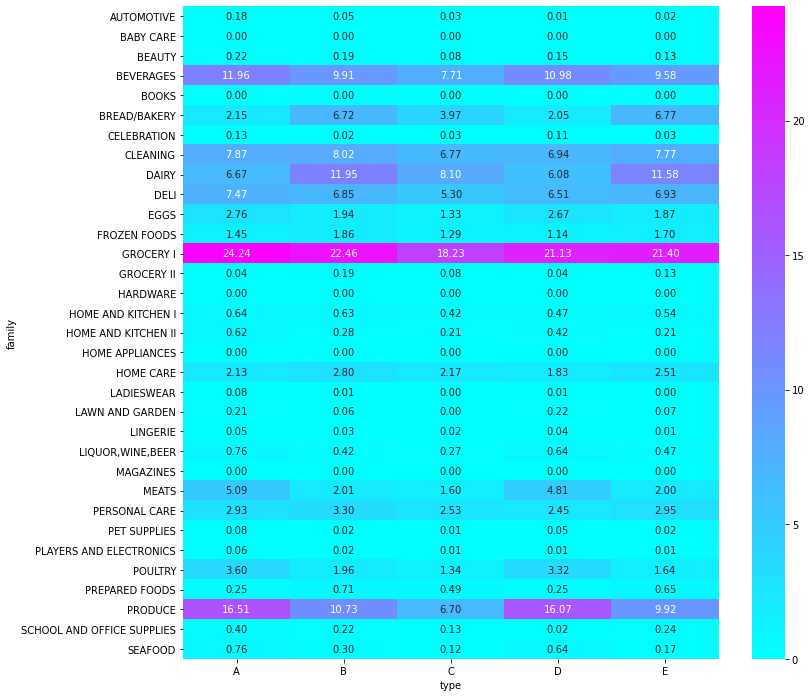

In [28]:
plt.figure(figsize=(12,12))
promo_heat = type_promo.pivot_table(values="onpromotion",index="family", columns="type",aggfunc=np.mean)
show = sns.heatmap(promo_heat, cmap="cool", annot=True, fmt=".2f")

In [29]:
sales_plus

date  store_nbr                      family     sales  \
0       2013-01-01          1                  AUTOMOTIVE     0.000   
1       2013-01-01          1                   BABY CARE     0.000   
2       2013-01-01          1                      BEAUTY     0.000   
3       2013-01-01          1                   BEVERAGES     0.000   
4       2013-01-01          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3000883 2017-08-15          9                     POULTRY   438.133   
3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion   city      state type  cluster  
0                  0  Quito  Pichincha    D       13  
1                  0  Quito  Pichincha    D       13  
2                  0  Quito  Pichincha    D       13  
3                  0  Quito  Pichincha    D       13  
4                  0  Quito  Pichincha    D       13  
...              ...    ...        ...  ...      ...  
3000883            0  Quito  Pichincha    B        6  
3000884            1  Quito  Pichincha    B        6  
3000885          148  Quito  Pichincha    B        6  
3000886            8  Quito  Pichincha    B        6  
3000887            0  Quito  Pichincha    B        6  

[3000888 rows x 9 columns]

In [30]:
sales_plus["promo_day"] = np.where(sales_plus["onpromotion"] > 0, 1, 0)
sales_plus

date  store_nbr                      family     sales  \
0       2013-01-01          1                  AUTOMOTIVE     0.000   
1       2013-01-01          1                   BABY CARE     0.000   
2       2013-01-01          1                      BEAUTY     0.000   
3       2013-01-01          1                   BEVERAGES     0.000   
4       2013-01-01          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3000883 2017-08-15          9                     POULTRY   438.133   
3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion   city      state type  cluster  promo_day  
0                  0  Quito  Pichincha    D       13          0  
1                  0  Quito  Pichincha    D       13          0  
2                  0  Quito  Pichincha    D       13          0  
3                  0  Quito  Pichincha    D       13          0  
4                  0  Quito  Pichincha    D       13          0  
...              ...    ...        ...  ...      ...        ...  
3000883            0  Quito  Pichincha    B        6          0  
3000884            1  Quito  Pichincha    B        6          1  
3000885          148  Quito  Pichincha    B        6          1  
3000886            8  Quito  Pichincha    B        6          1  
3000887            0  Quito  Pichincha    B        6          0  

[3000888 rows x 10 columns]

In [31]:
type_promo = pd.DataFrame(sales_plus.groupby(["store_nbr", "type","family"]).promo_day.sum())
type_promo.reset_index(inplace=True)
type_promo["store_nbr"] = type_promo["store_nbr"].astype(object)
type_promo["type"] = type_promo["type"].astype(object)
type_promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  1782 non-null   object
 1   type       1782 non-null   object
 2   family     1782 non-null   object
 3   promo_day  1782 non-null   int32 
dtypes: int32(1), object(3)
memory usage: 48.9+ KB


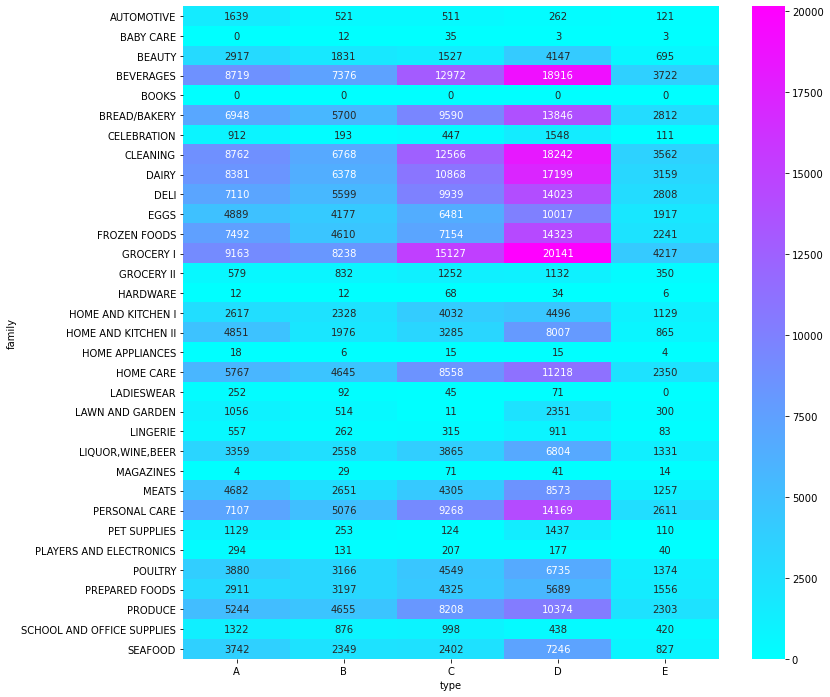

In [32]:
plt.figure(figsize=(12,12))
promo_heat = type_promo.pivot_table(values="promo_day",index="family", columns="type",aggfunc=np.sum)
show = sns.heatmap(promo_heat, cmap="cool", annot=True, fmt="d")

In [33]:
sales_plus

date  store_nbr                      family     sales  \
0       2013-01-01          1                  AUTOMOTIVE     0.000   
1       2013-01-01          1                   BABY CARE     0.000   
2       2013-01-01          1                      BEAUTY     0.000   
3       2013-01-01          1                   BEVERAGES     0.000   
4       2013-01-01          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3000883 2017-08-15          9                     POULTRY   438.133   
3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion   city      state type  cluster  promo_day  
0                  0  Quito  Pichincha    D       13          0  
1                  0  Quito  Pichincha    D       13          0  
2                  0  Quito  Pichincha    D       13          0  
3                  0  Quito  Pichincha    D       13          0  
4                  0  Quito  Pichincha    D       13          0  
...              ...    ...        ...  ...      ...        ...  
3000883            0  Quito  Pichincha    B        6          0  
3000884            1  Quito  Pichincha    B        6          1  
3000885          148  Quito  Pichincha    B        6          1  
3000886            8  Quito  Pichincha    B        6          1  
3000887            0  Quito  Pichincha    B        6          0  

[3000888 rows x 10 columns]

In [34]:
sales_stable = sales_plus.loc[~sales_plus["store_nbr"].isin([12, 14, 20, 21, 22, 24, 25, 29, 36, 42, 52, 53])]
sales_stable["store_nbr"].unique()

array([ 1, 10, 11, 13, 15, 16, 17, 18, 19,  2, 23, 26, 27, 28,  3, 30, 31,
       32, 33, 34, 35, 37, 38, 39,  4, 40, 41, 43, 44, 45, 46, 47, 48, 49,
        5, 50, 51, 54,  6,  7,  8,  9], dtype=int64)

In [35]:
family_sales = pd.DataFrame(sales_stable.groupby(["family","date"]).sales.sum())
family_sales

sales
family     date                   
AUTOMOTIVE 2013-01-01     0.000000
           2013-01-02   242.000000
           2013-01-03   152.000000
           2013-01-04   155.000000
           2013-01-05   323.000000
...                            ...
SEAFOOD    2017-08-11  1133.023997
           2017-08-12   915.388007
           2017-08-13  1013.964000
           2017-08-14   875.070998
           2017-08-15   888.343005

[55572 rows x 1 columns]

In [36]:
from pandas.plotting import lag_plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

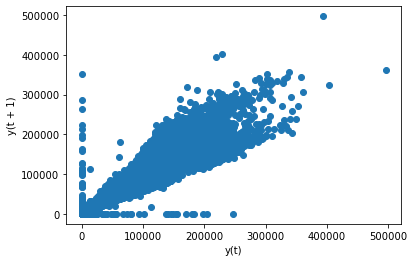

In [37]:
plt.figure()
lag_plot(family_sales)

In [38]:
import statsmodels.api as sm
sales_mean = sales_stable[(sales_stable.sales.notnull())].groupby(["date", "family"]).sales.mean().reset_index().set_index("date")
family_unique = sales_mean.family.unique()

<ipython-input-39-164e4fb973f1>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3,figsize=(25,3))


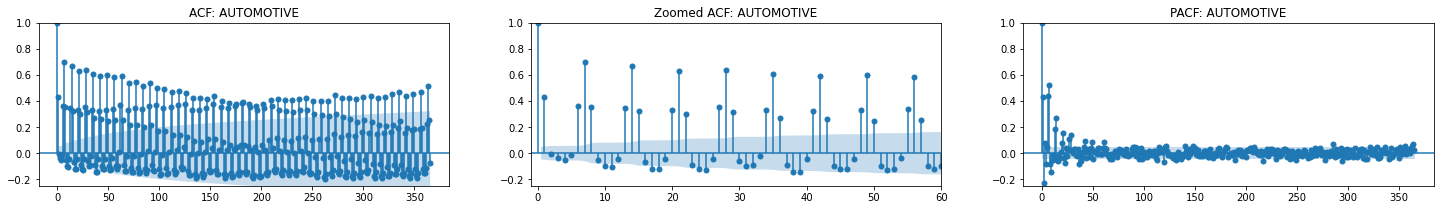

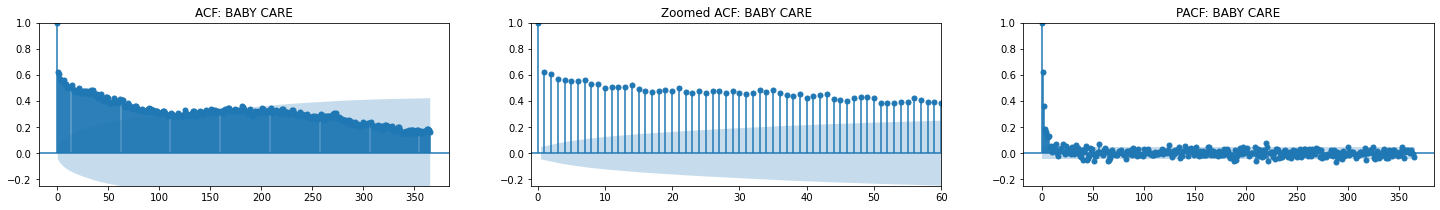

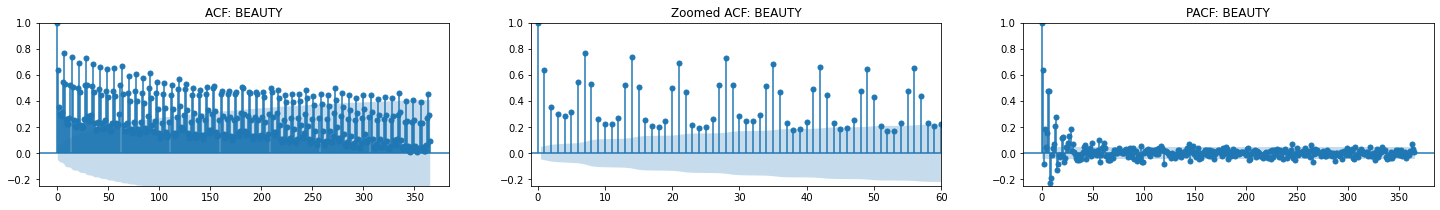

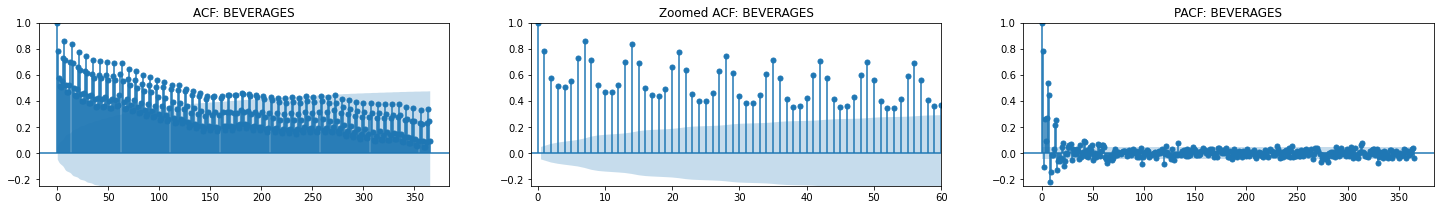

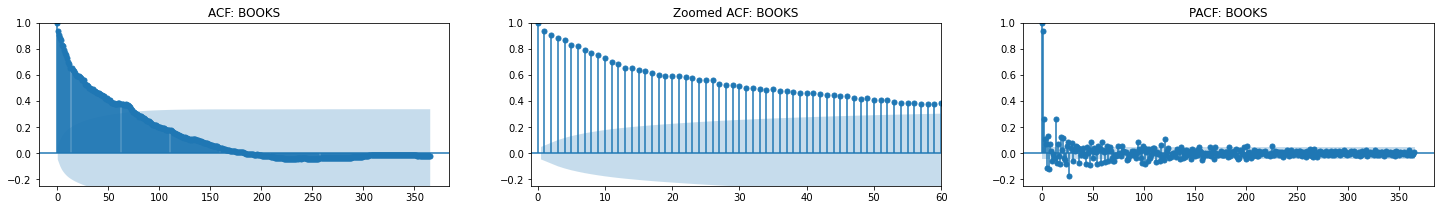

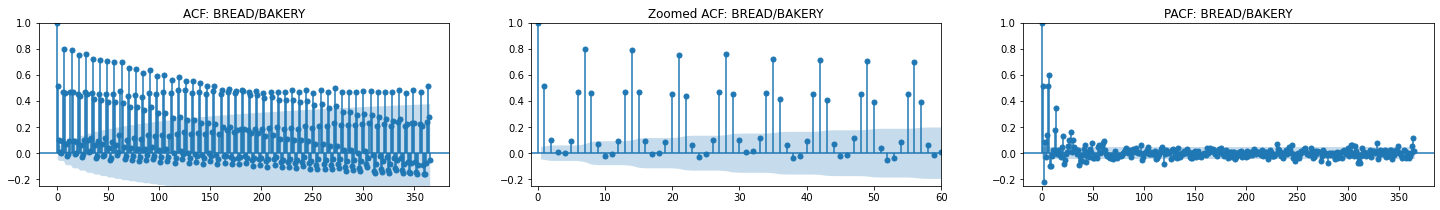

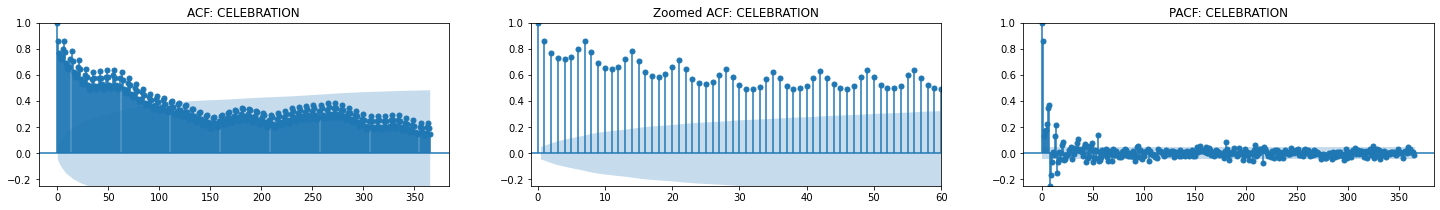

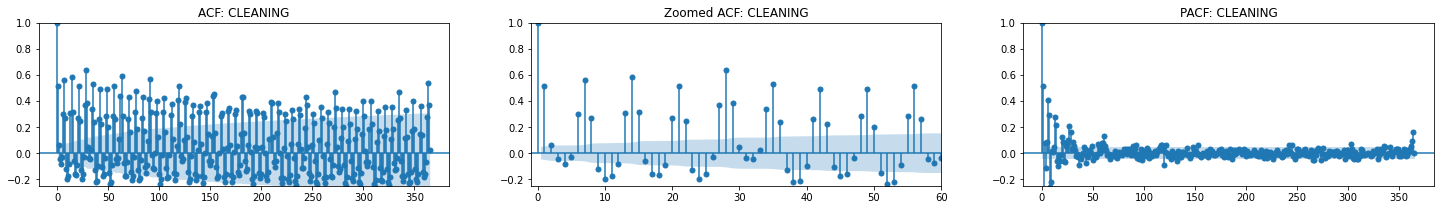

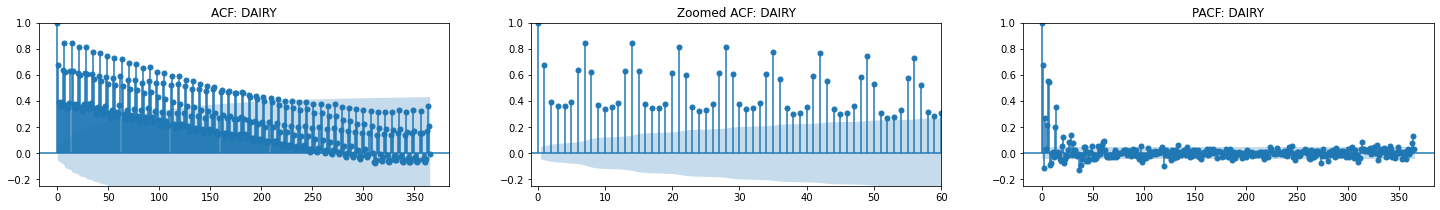

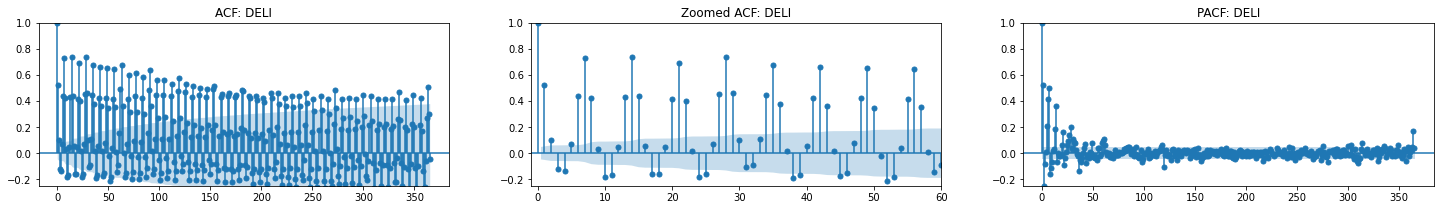

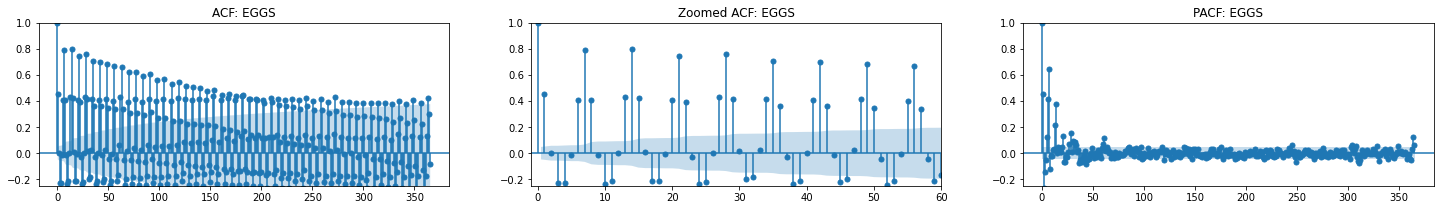

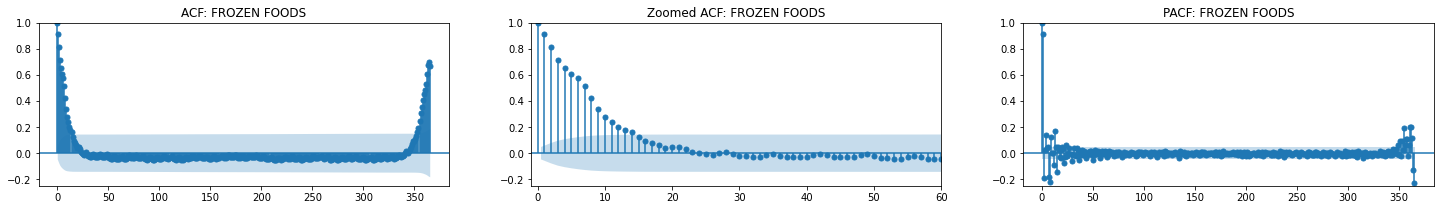

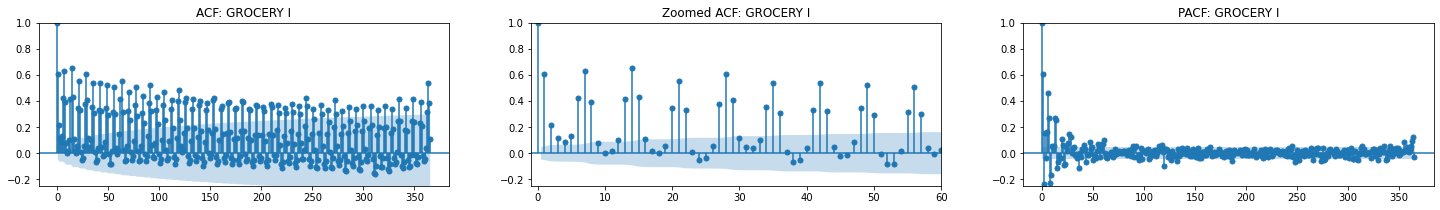

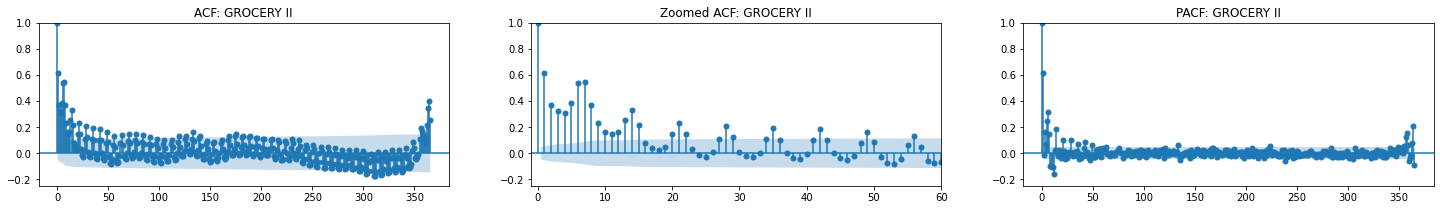

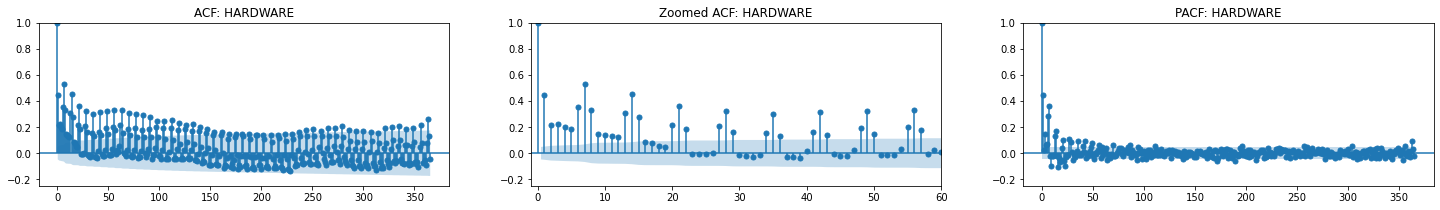

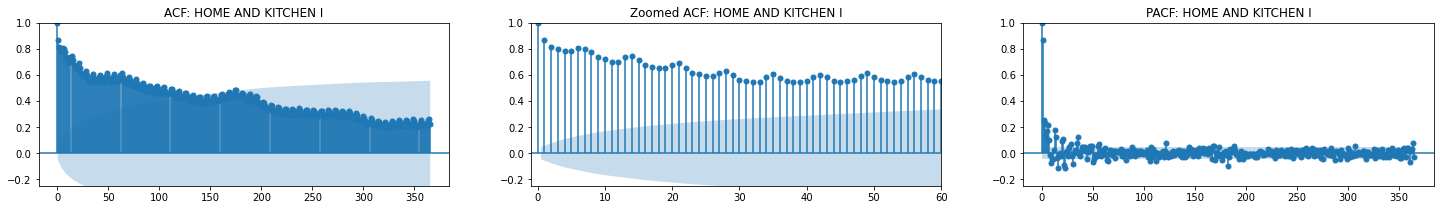

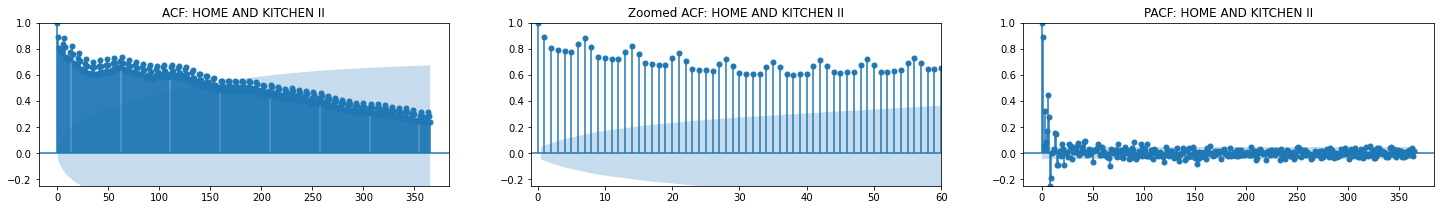

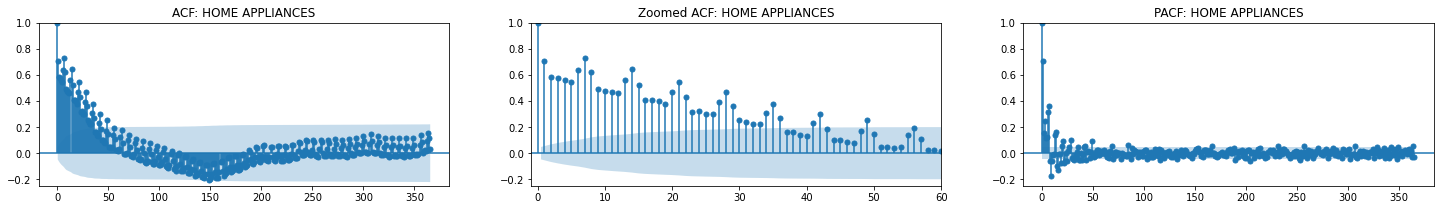

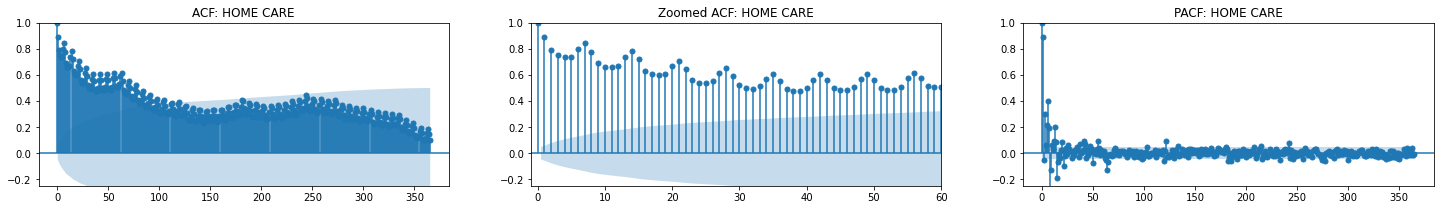

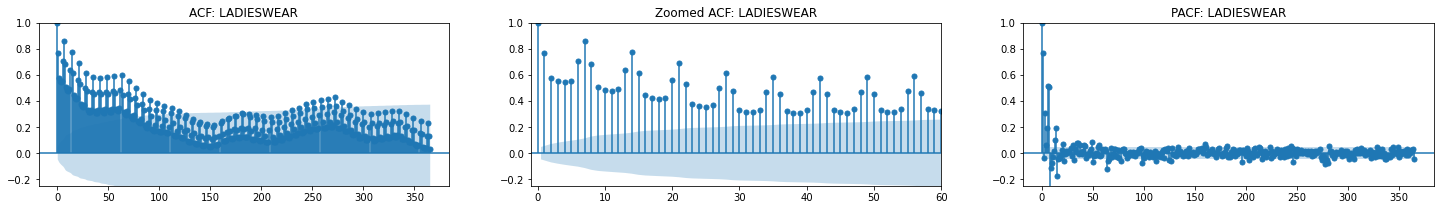

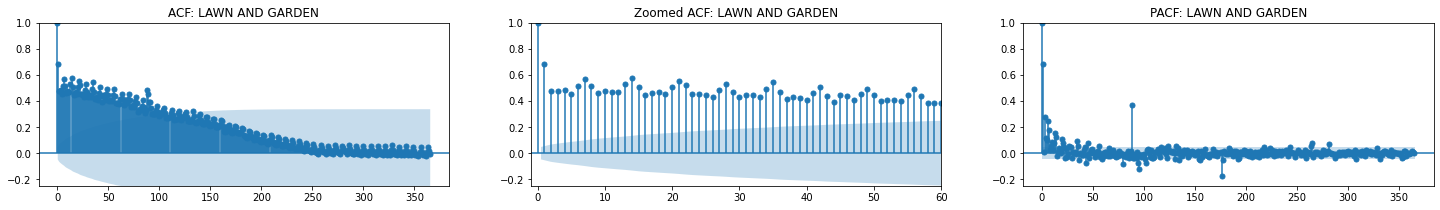

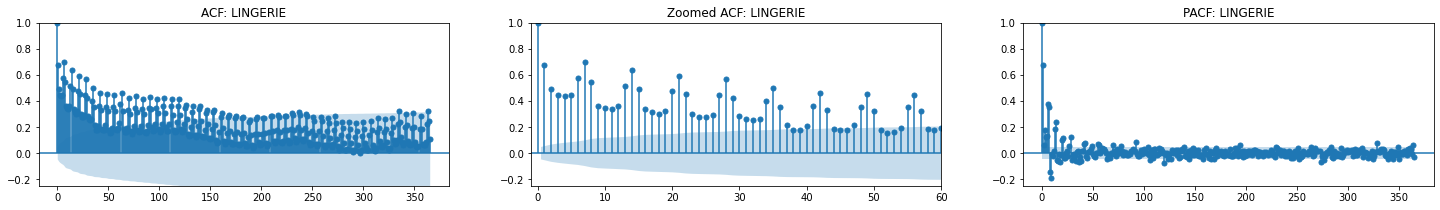

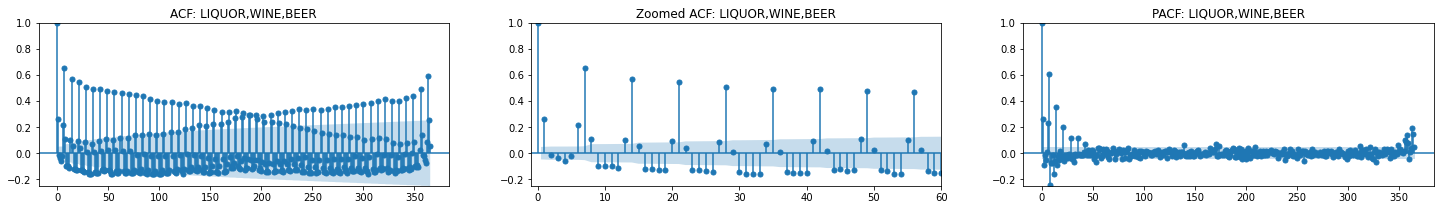

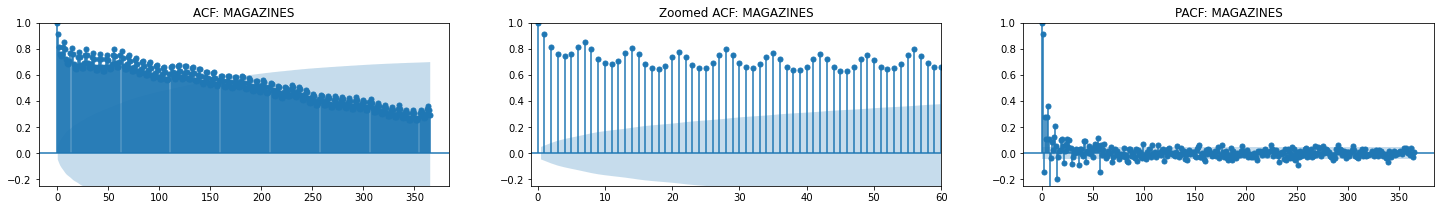

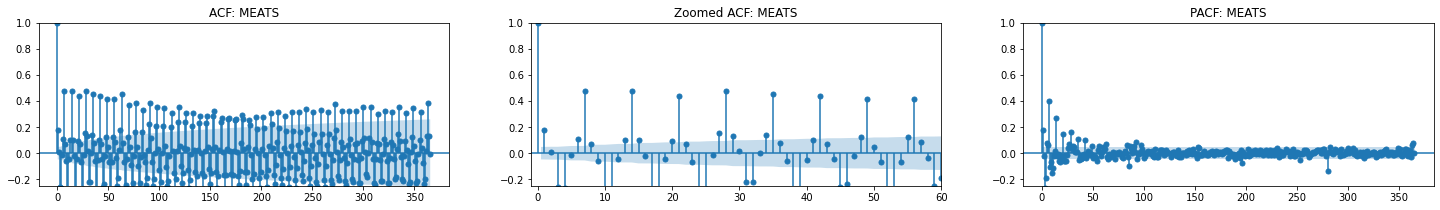

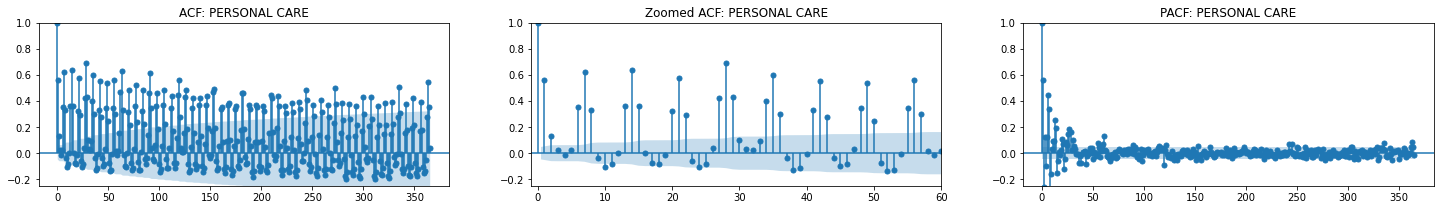

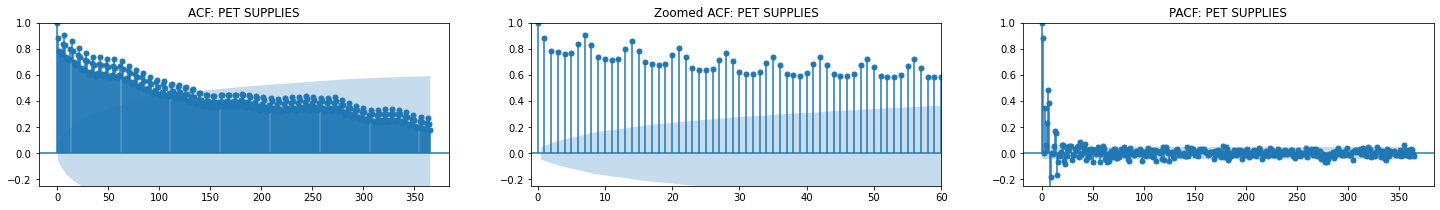

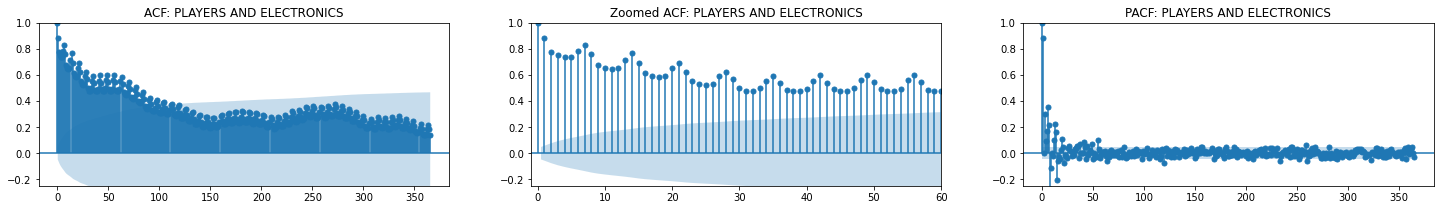

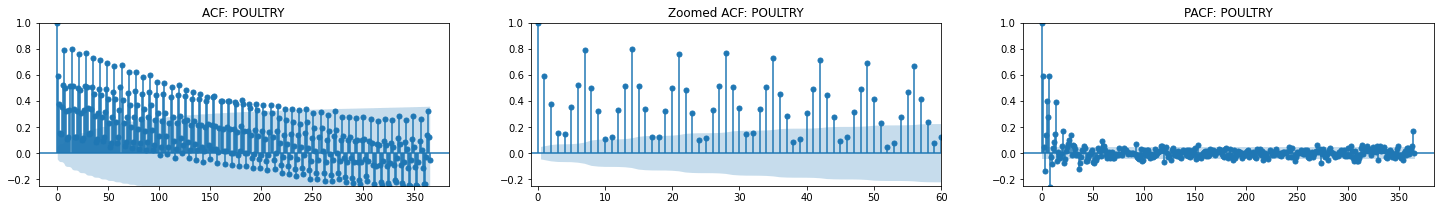

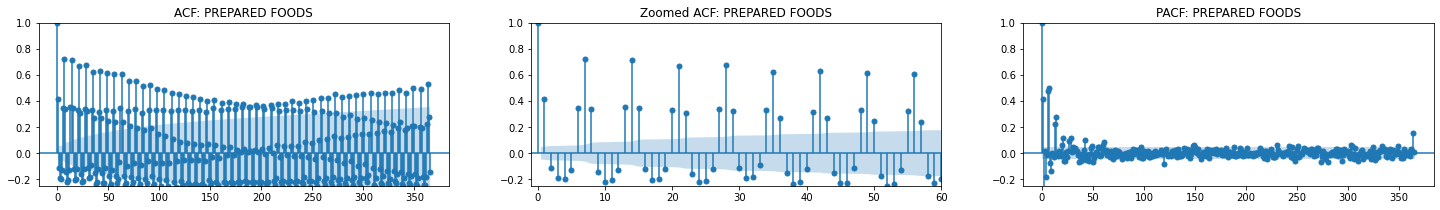

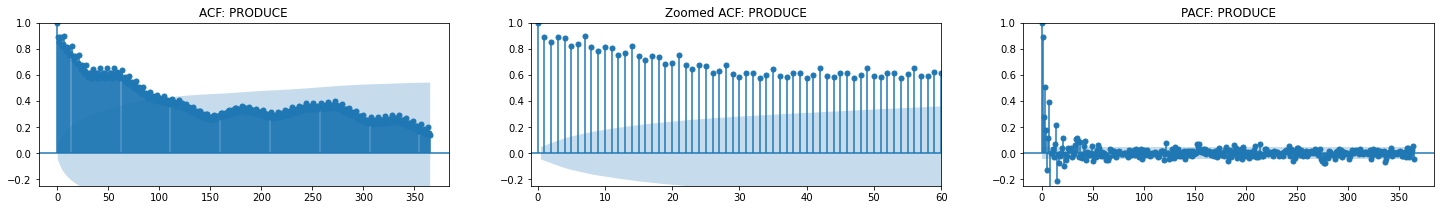

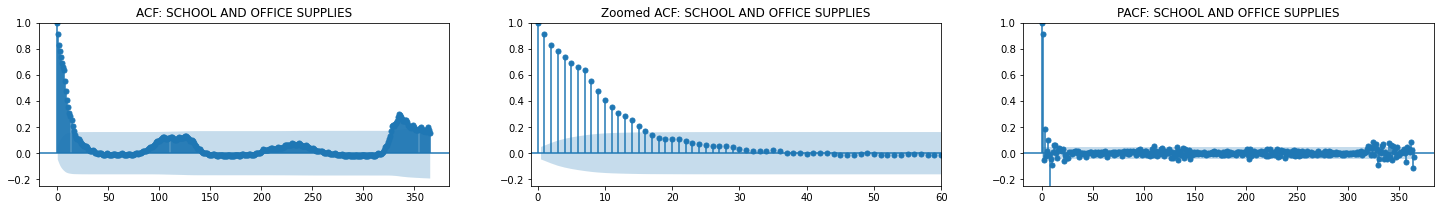

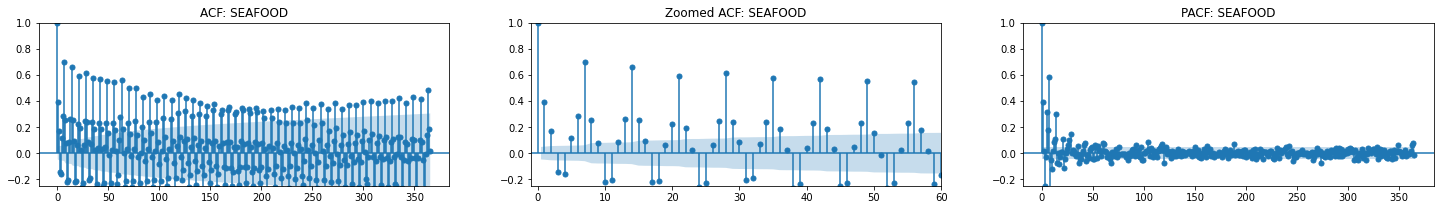

In [39]:
for num, i in enumerate(family_unique):
    fig, ax = plt.subplots(1,3,figsize=(25,3))
    temp = sales_mean[(sales_mean.family == i)]
    sm.graphics.tsa.plot_acf(temp.sales, lags=365, ax=ax[0], title = "ACF: " + i)
    sm.graphics.tsa.plot_acf(temp.sales, lags=365, ax=ax[1], title = "Zoomed ACF: " + i)
    sm.graphics.tsa.plot_pacf(temp.sales, lags=365, ax=ax[2], title = "PACF: " + i, method="ywm")
    ax[0].set(ylim=[-0.25,1])
    ax[1].set(xlim=[-1,60], ylim=[-0.25,1])
    ax[2].set(ylim=[-0.25,1])

<ipython-input-40-e8978f483707>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3,figsize=(25,3))


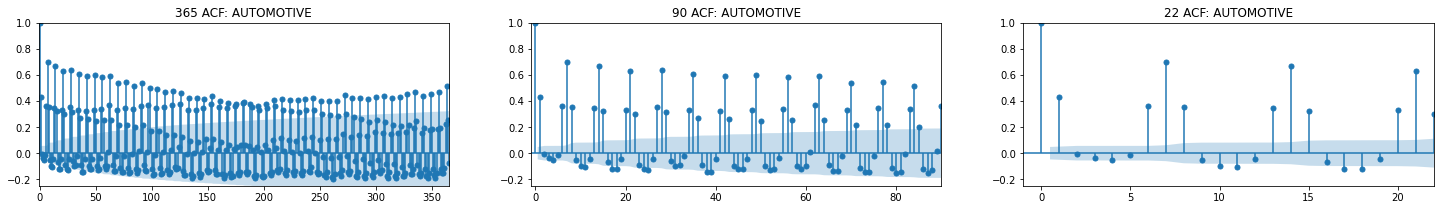

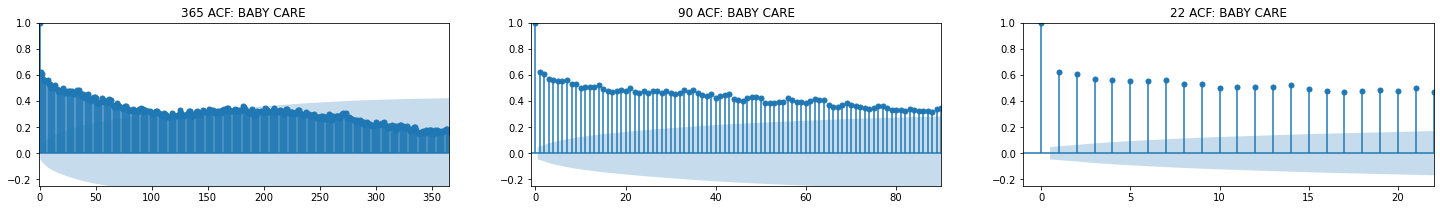

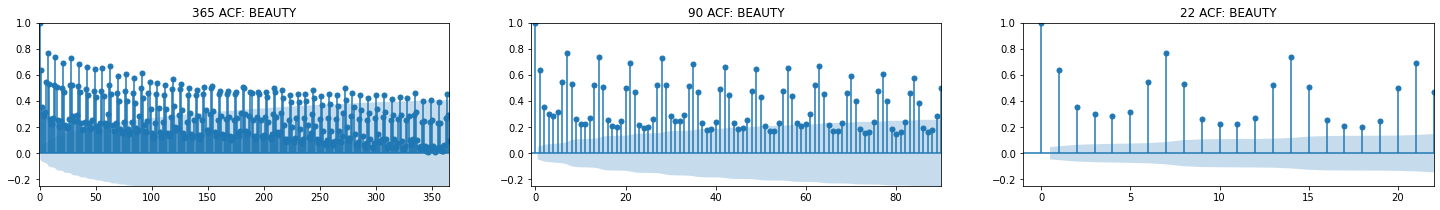

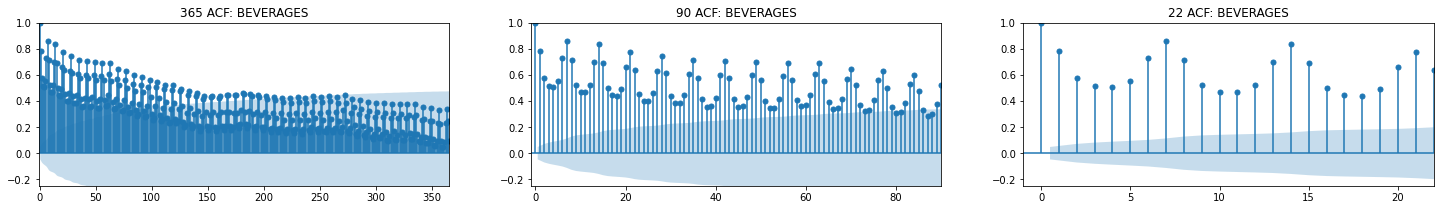

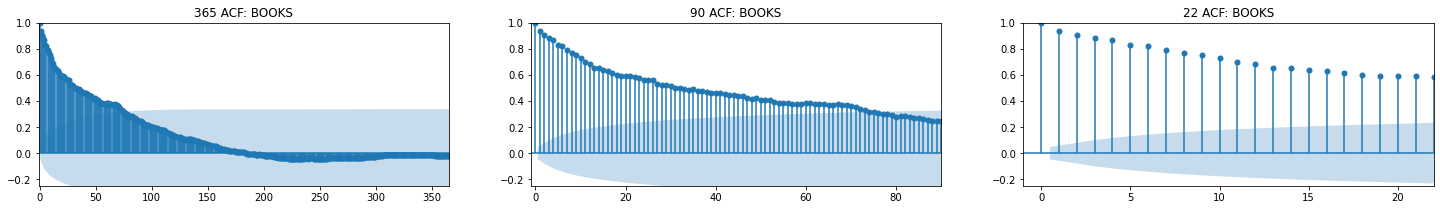

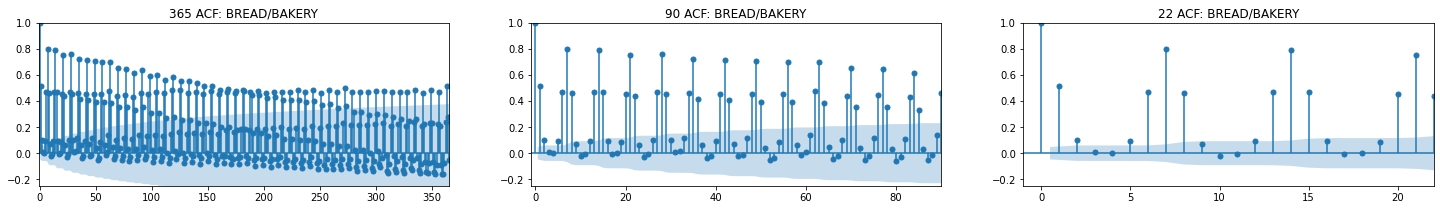

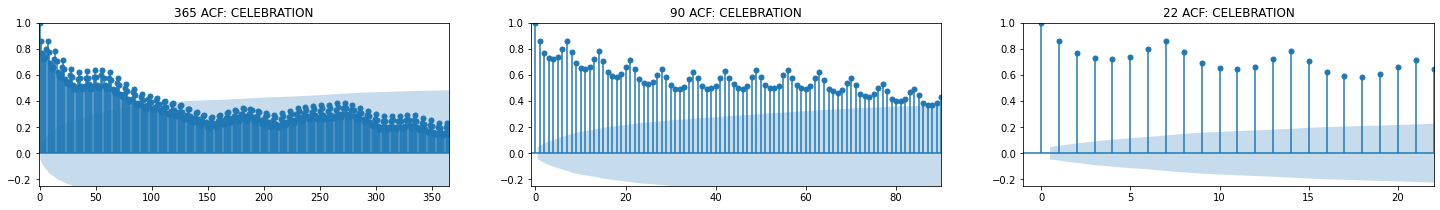

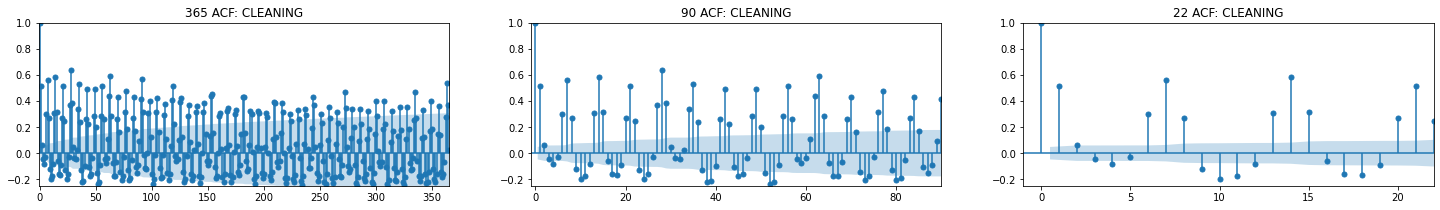

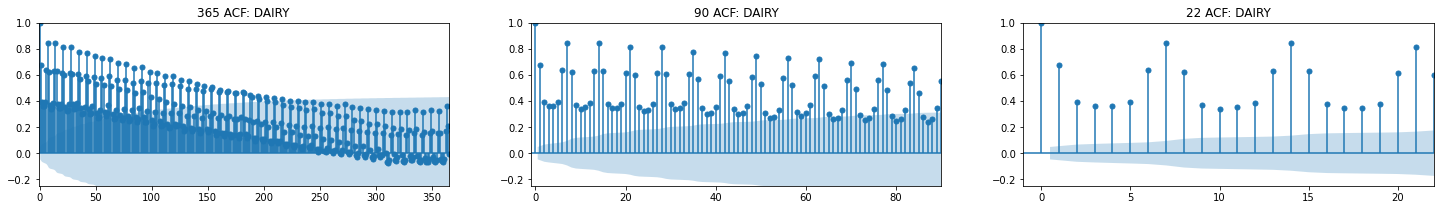

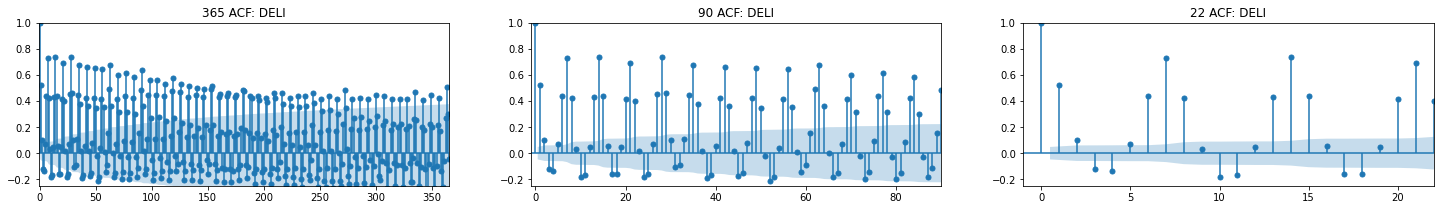

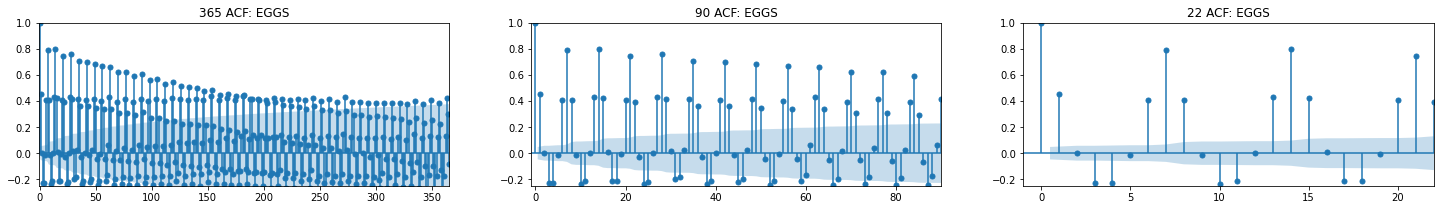

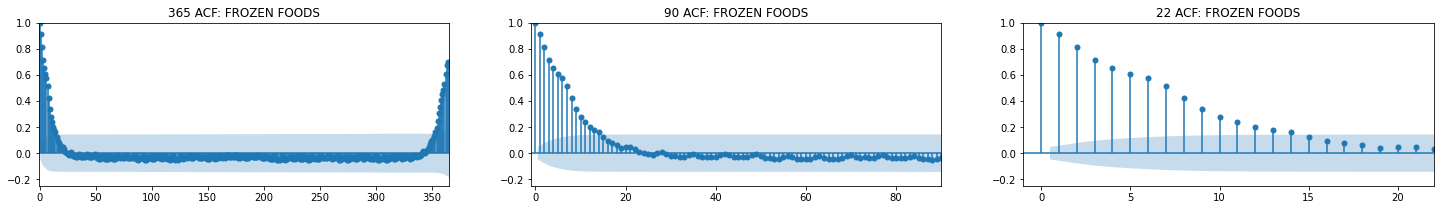

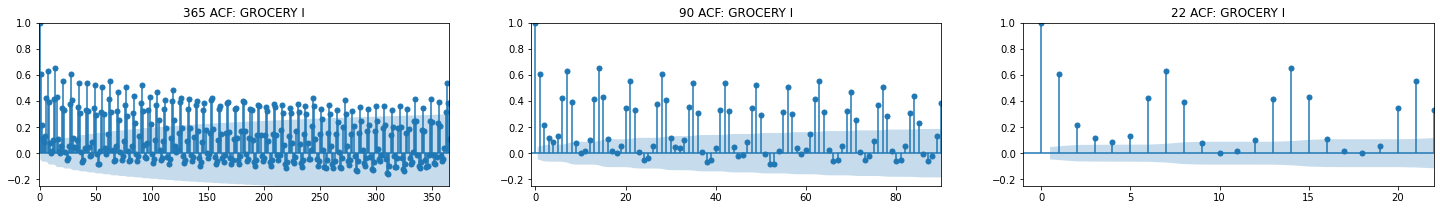

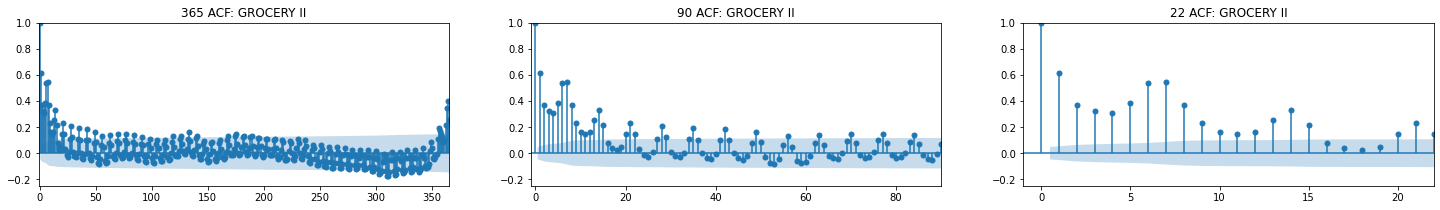

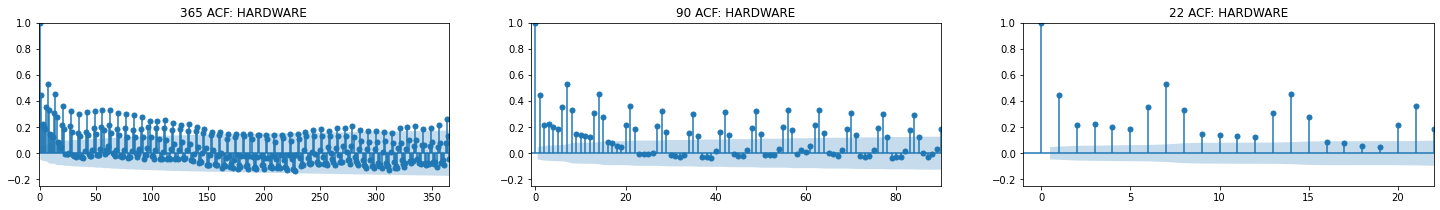

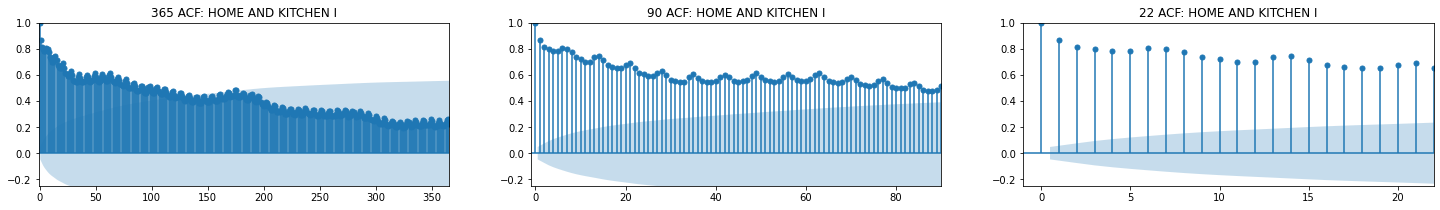

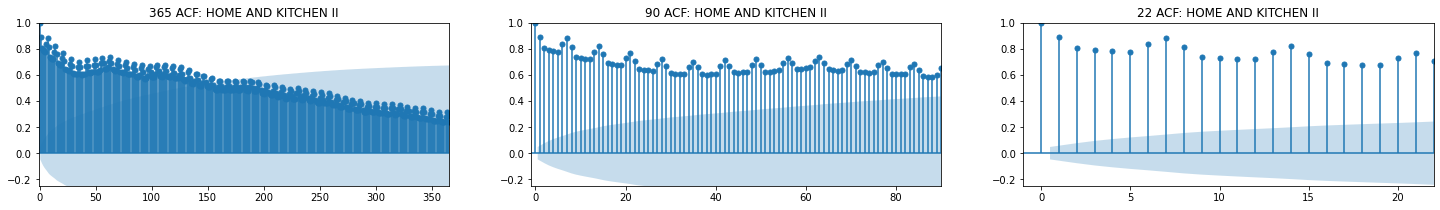

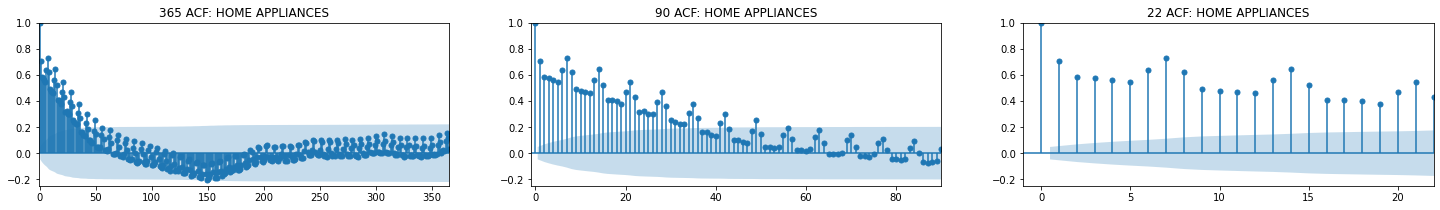

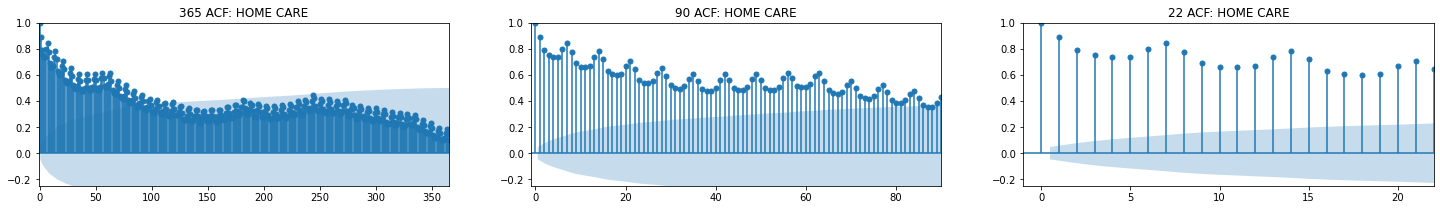

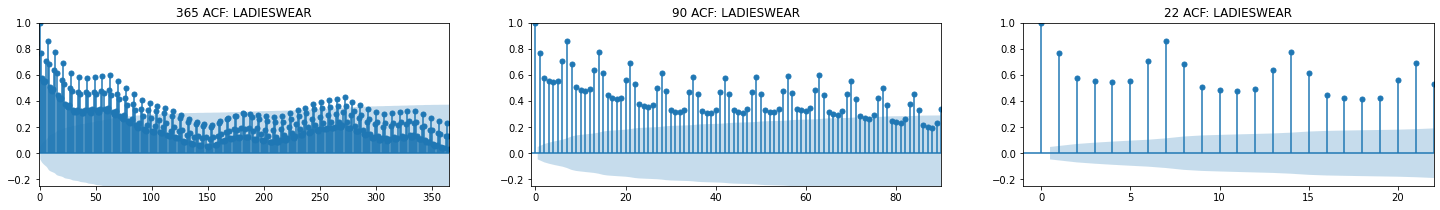

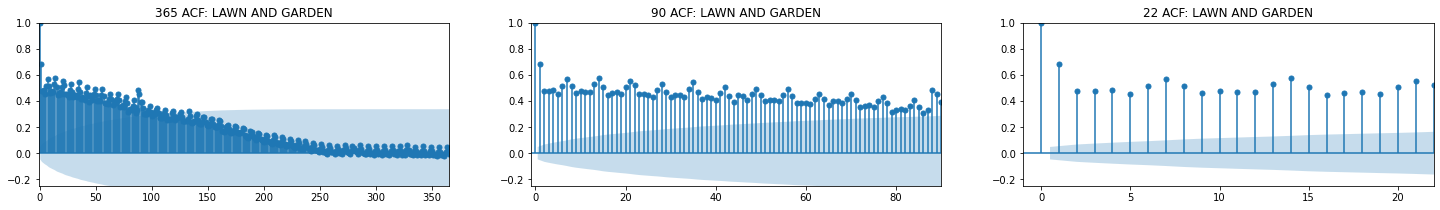

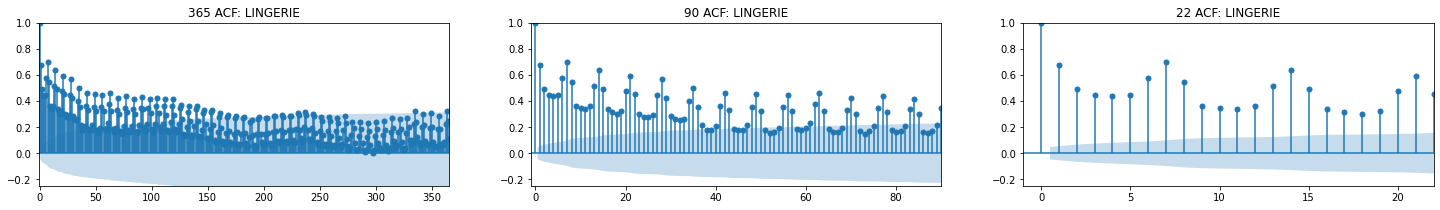

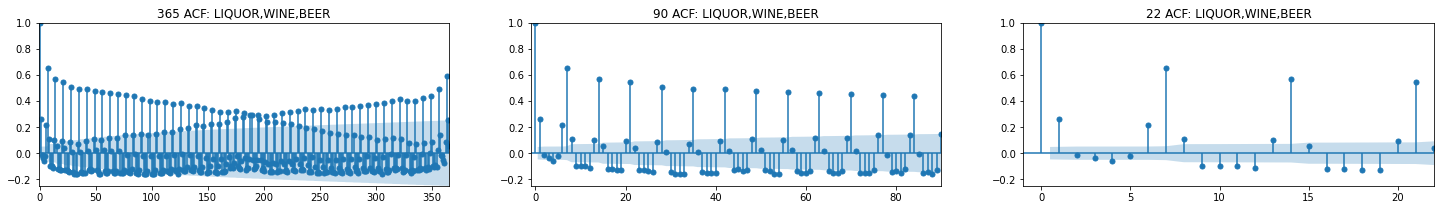

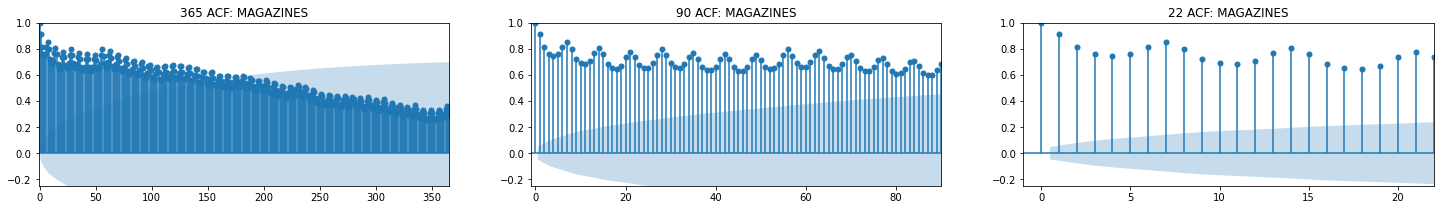

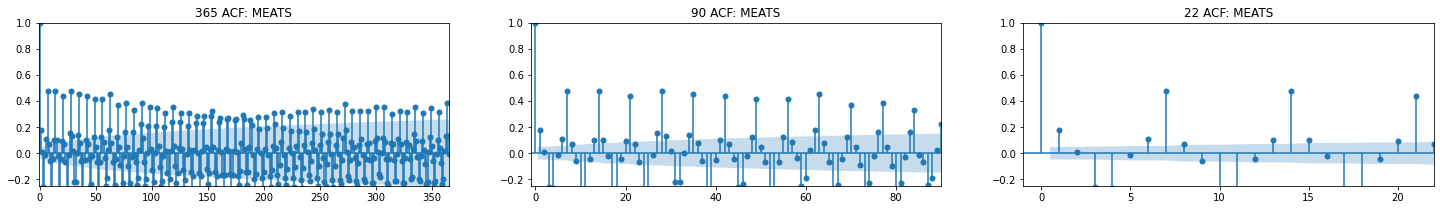

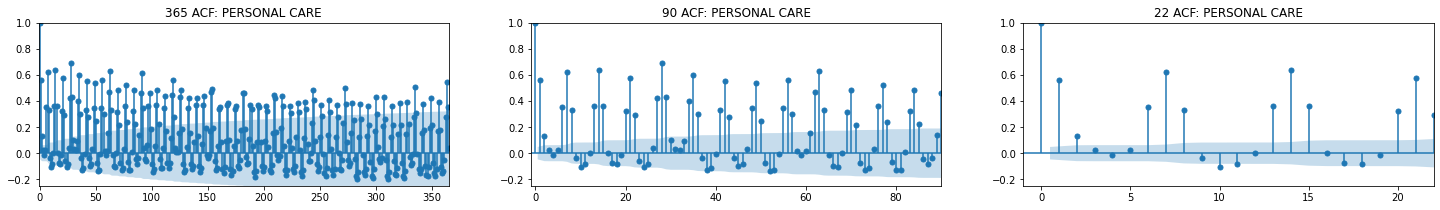

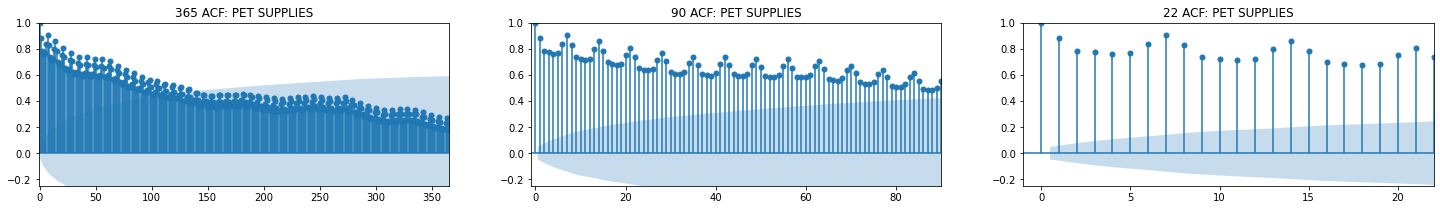

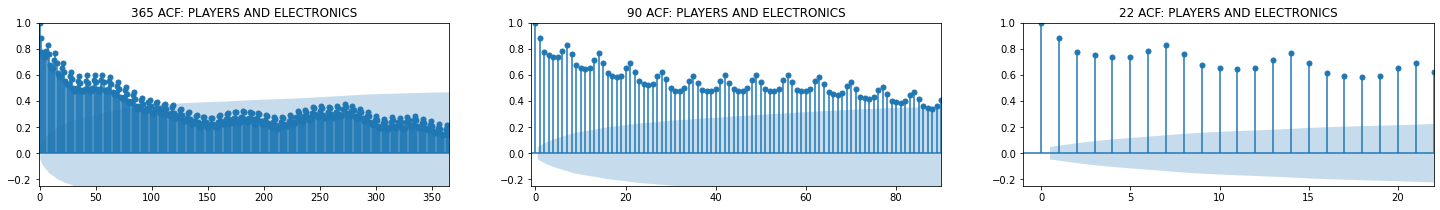

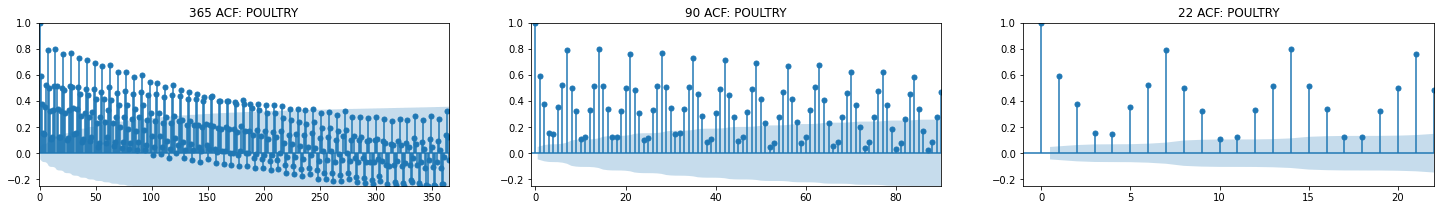

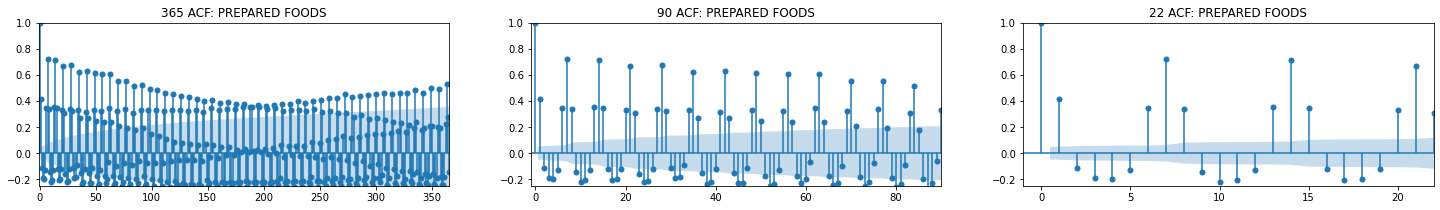

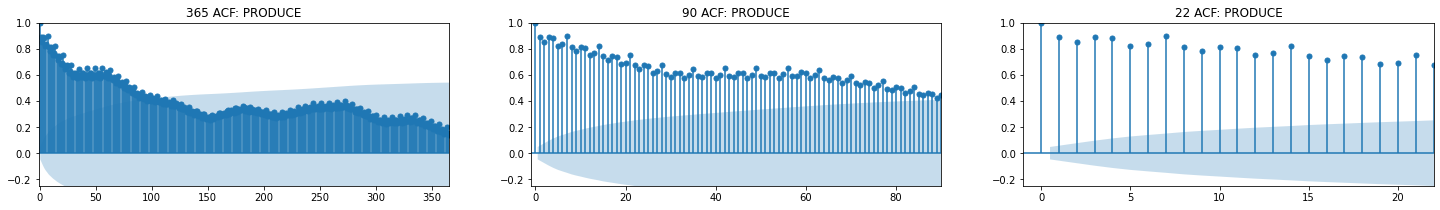

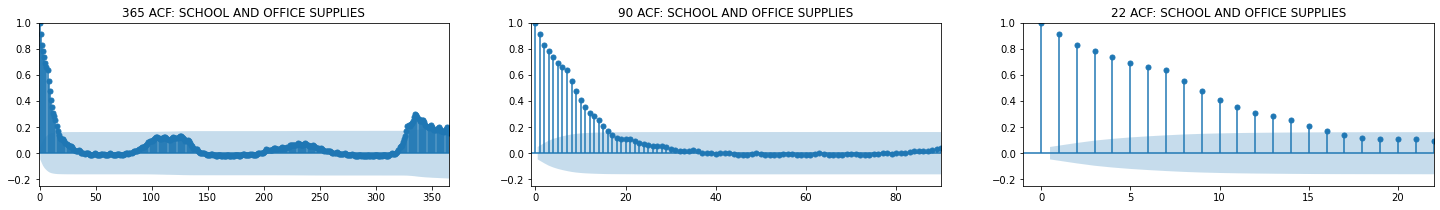

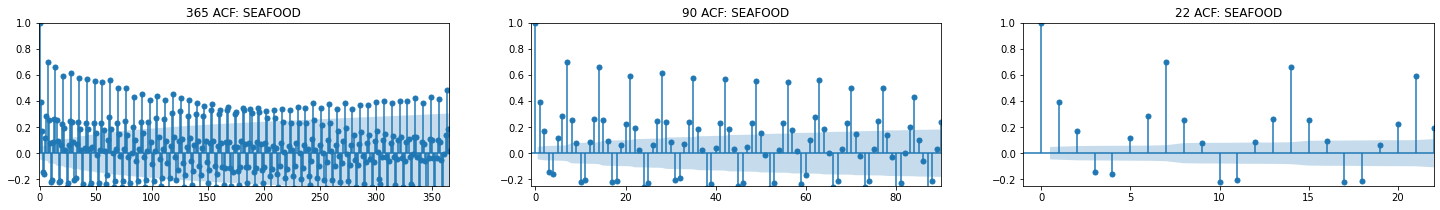

In [40]:
for num, i in enumerate(family_unique):
    fig, ax = plt.subplots(1,3,figsize=(25,3))
    temp = sales_mean[(sales_mean.family == i)]
    sm.graphics.tsa.plot_acf(temp.sales, lags=365, ax=ax[0], title = "365 ACF: " + i)
    sm.graphics.tsa.plot_acf(temp.sales, lags=365, ax=ax[1], title = "90 ACF: " + i)
    sm.graphics.tsa.plot_acf(temp.sales, lags=365, ax=ax[2], title = "22 ACF: " + i)
    ax[0].set(xlim=[-1,365], ylim=[-0.25,1])
    ax[1].set(xlim=[-1,90], ylim=[-0.25,1])
    ax[2].set(xlim=[-1,22], ylim=[-0.25,1])

<ipython-input-41-9bc7b73ff2ce>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3,figsize=(25,3))


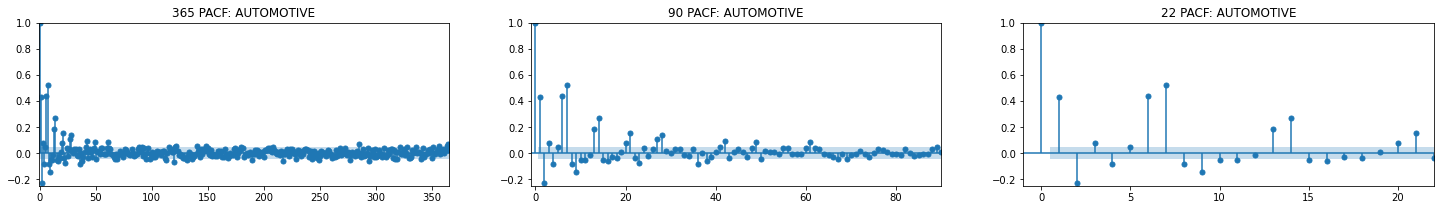

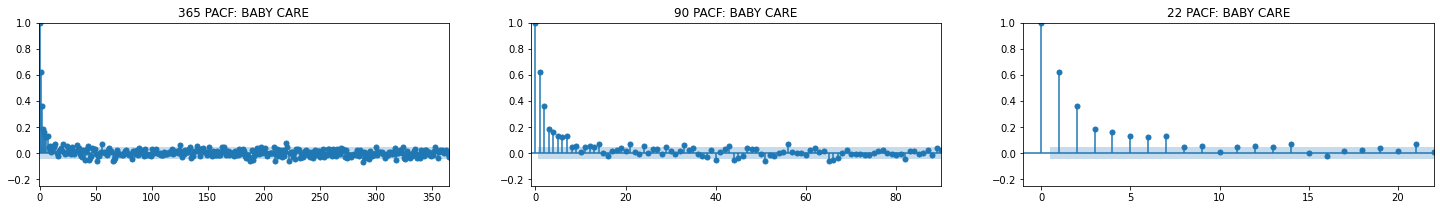

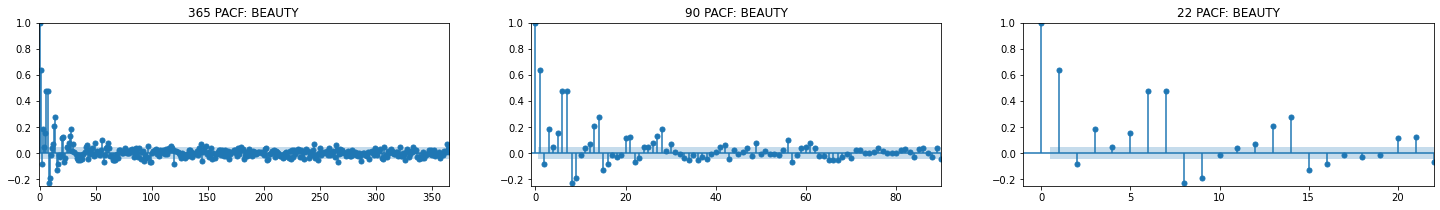

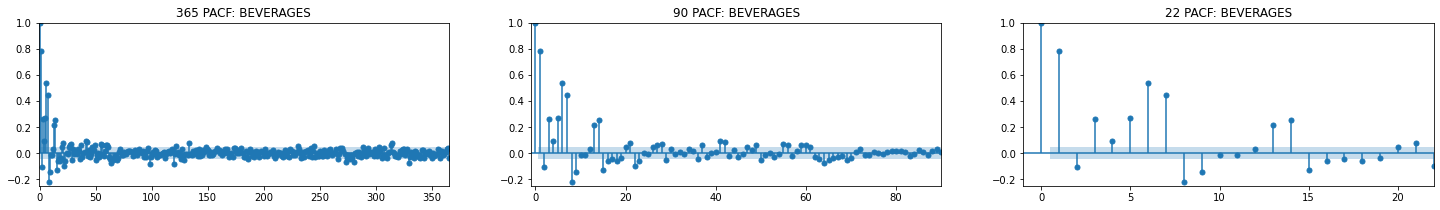

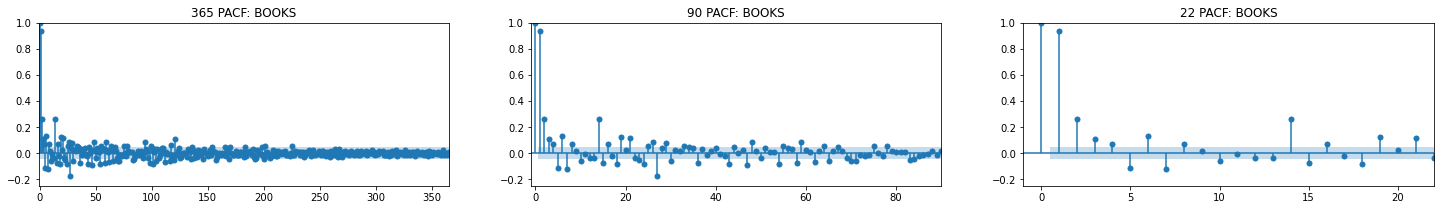

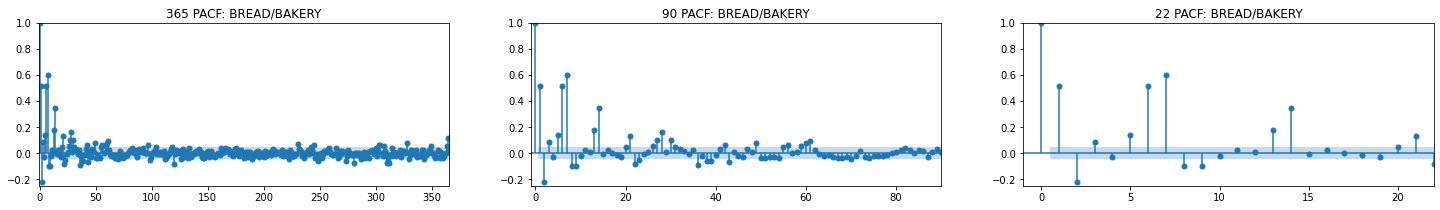

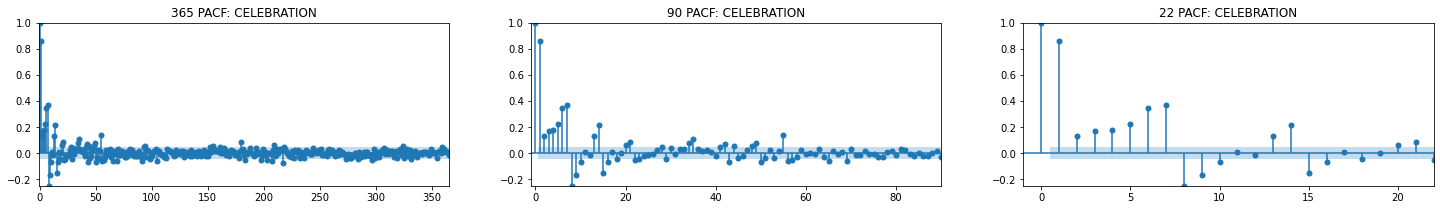

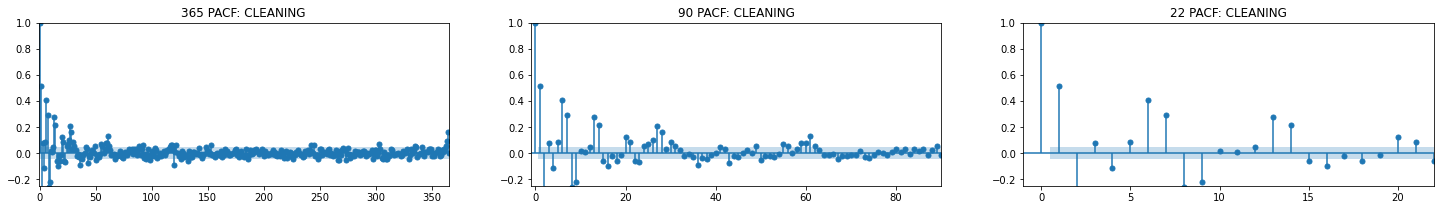

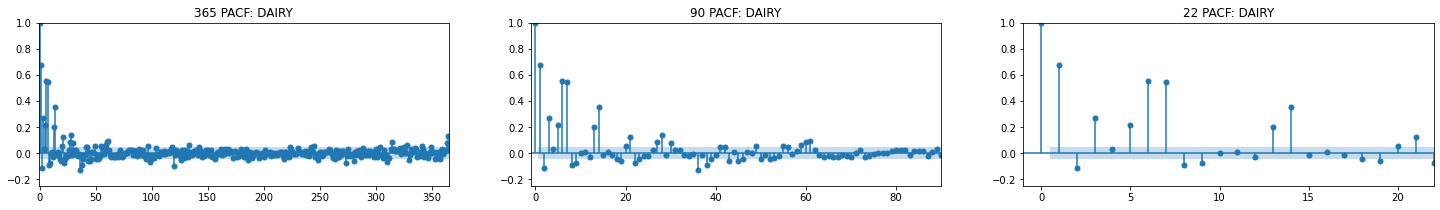

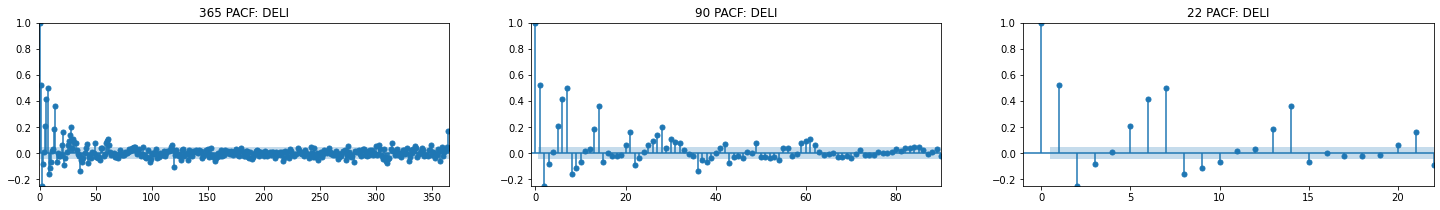

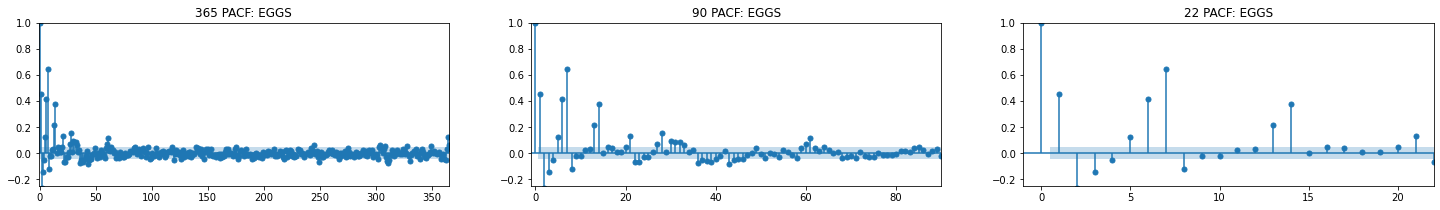

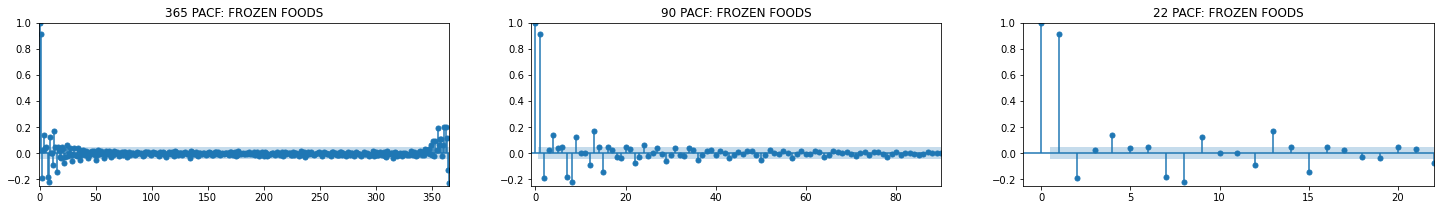

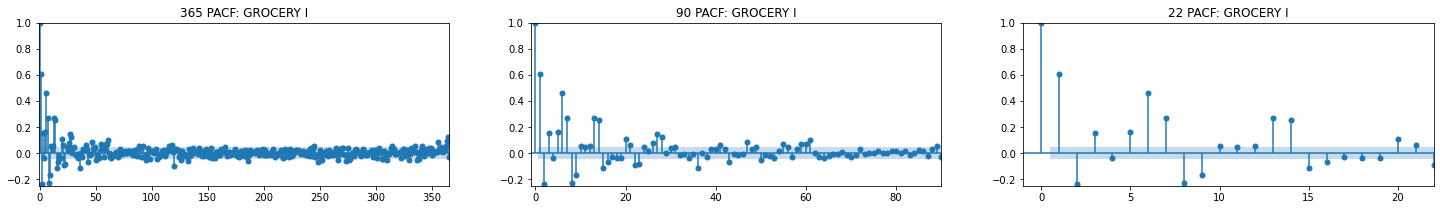

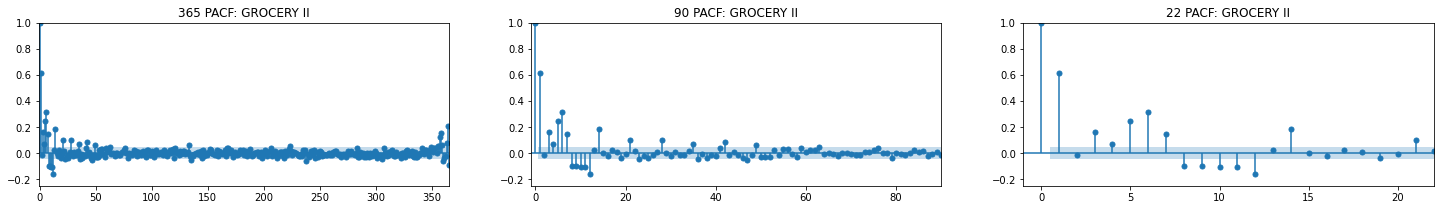

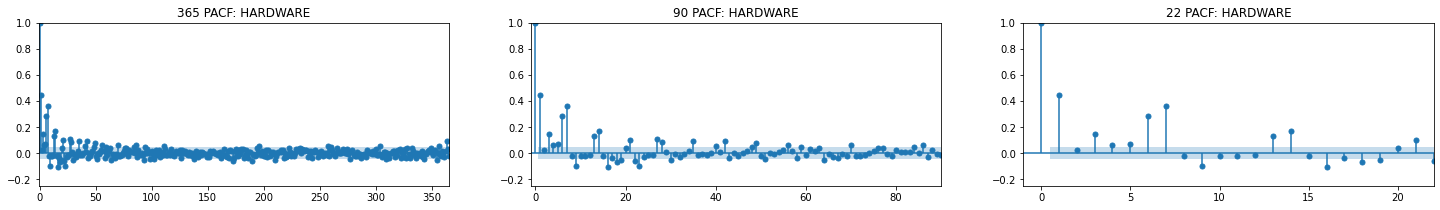

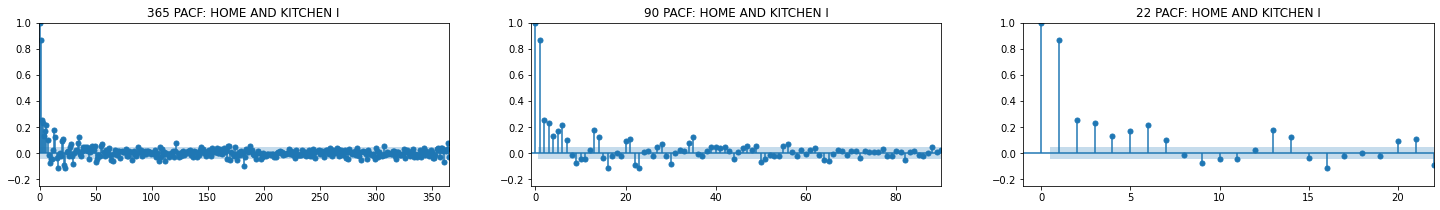

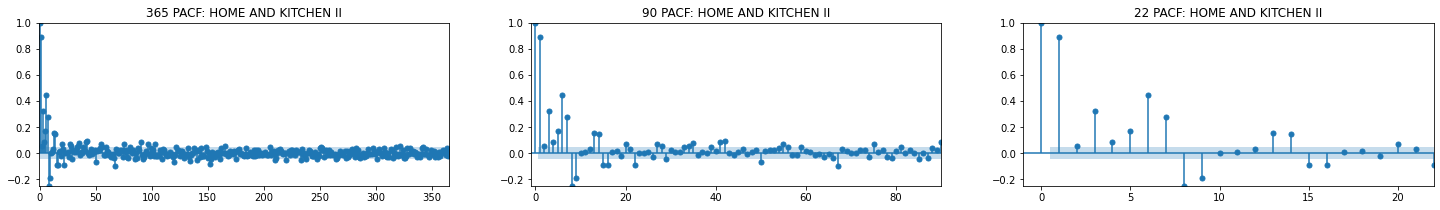

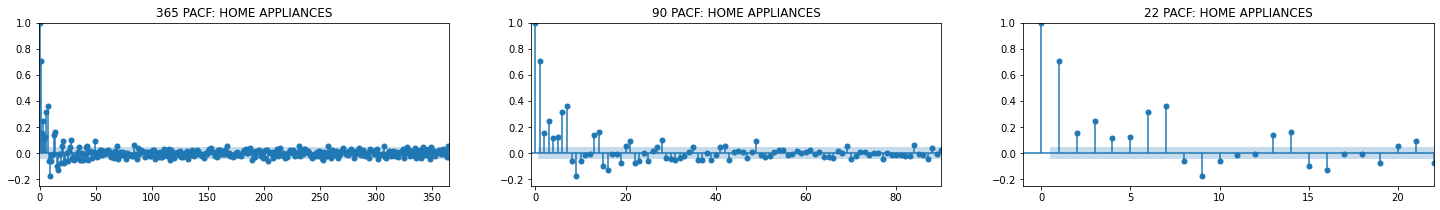

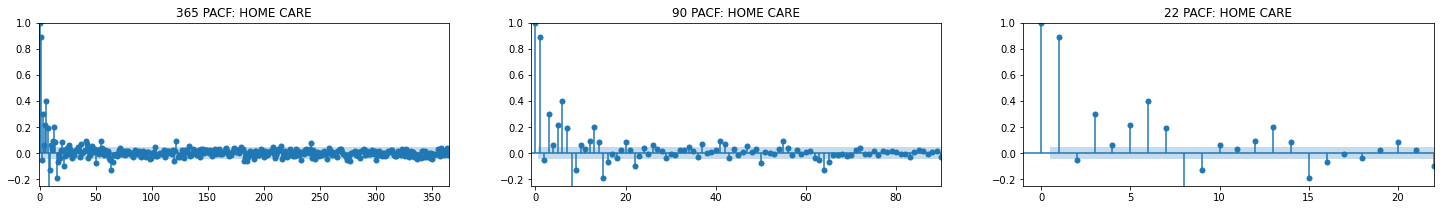

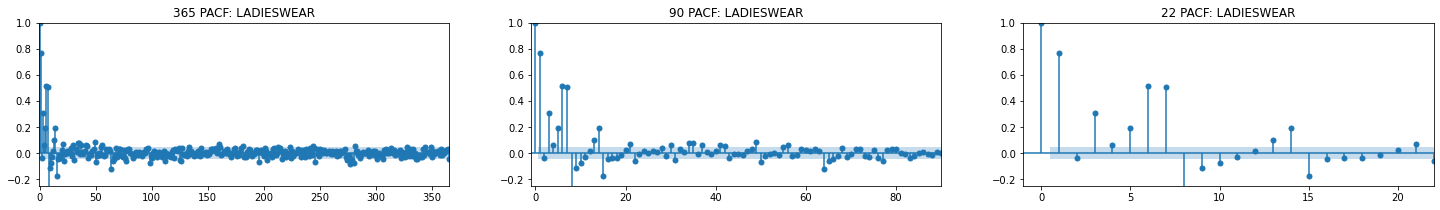

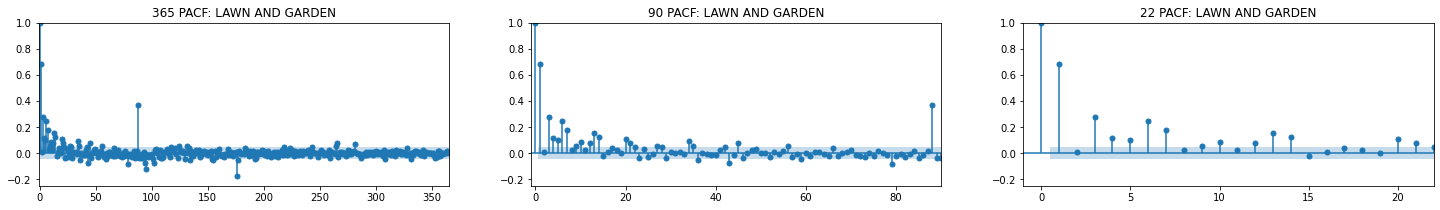

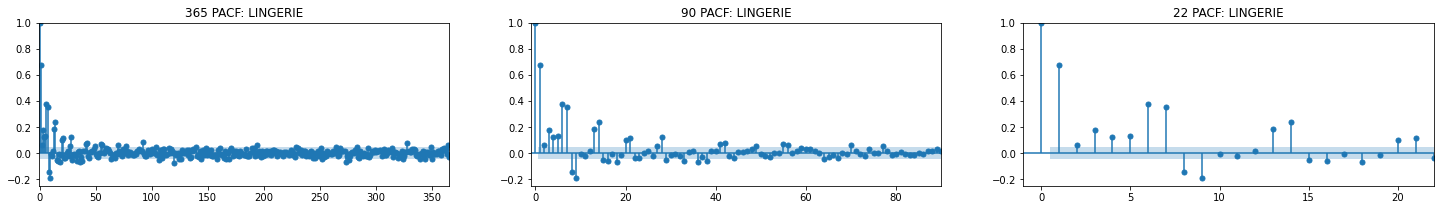

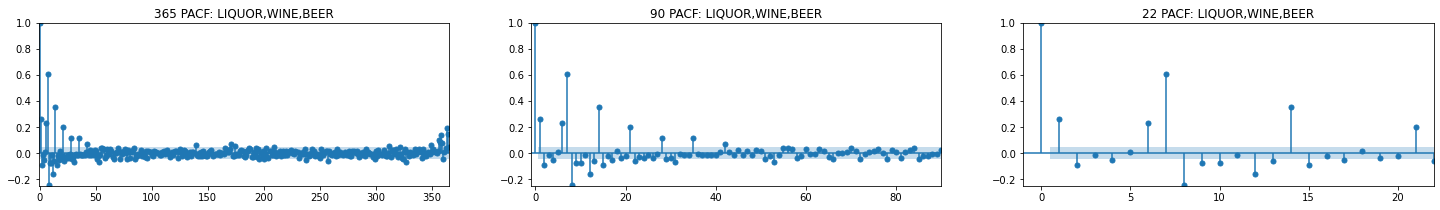

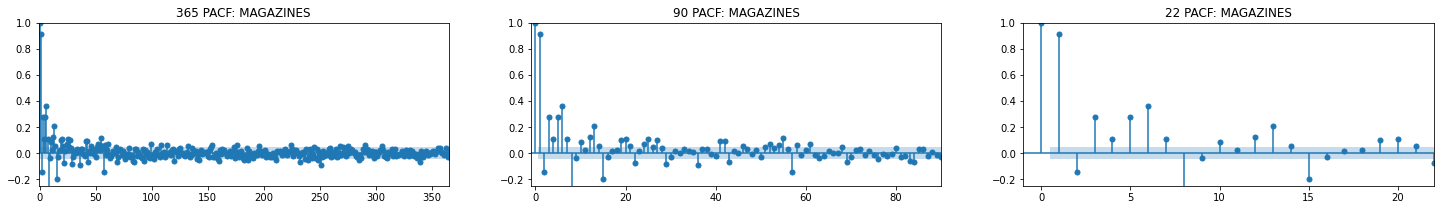

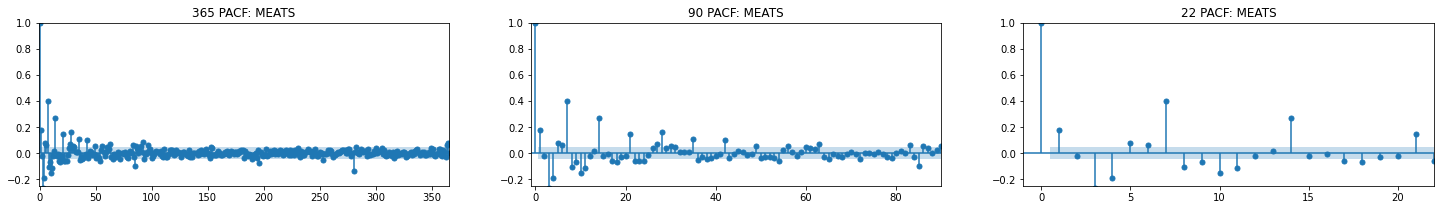

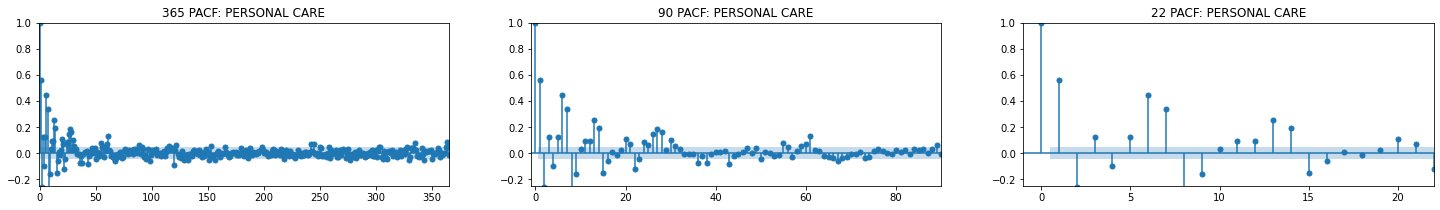

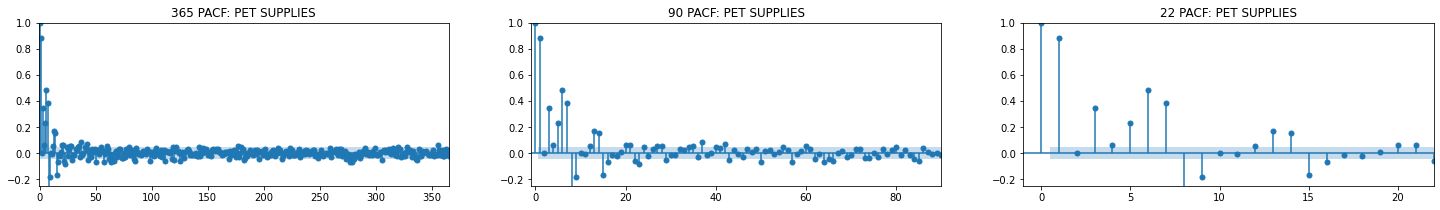

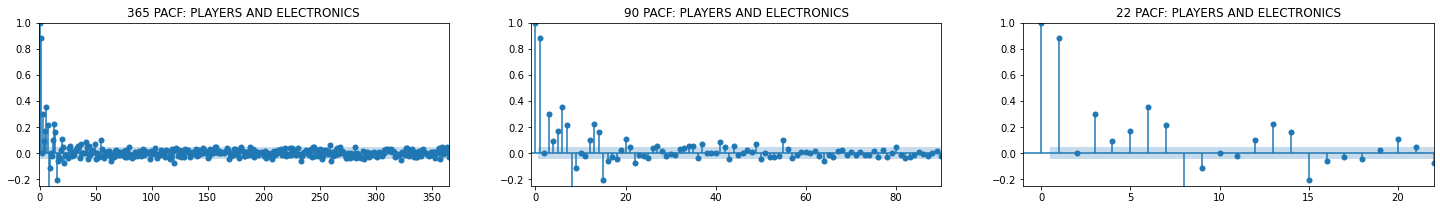

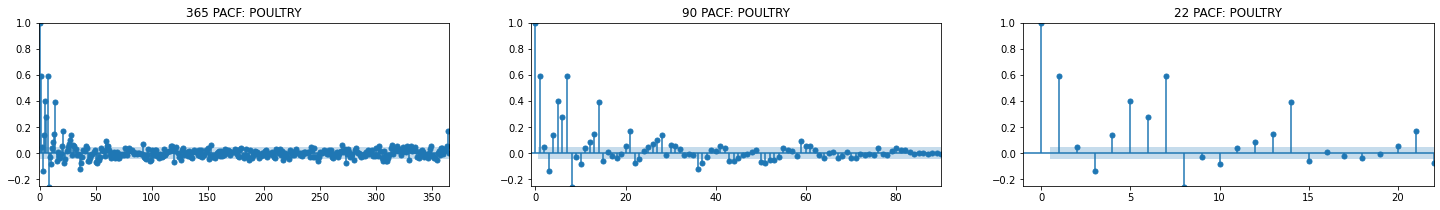

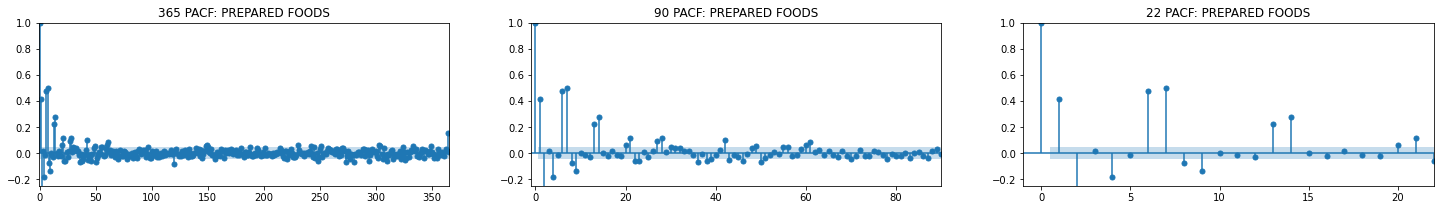

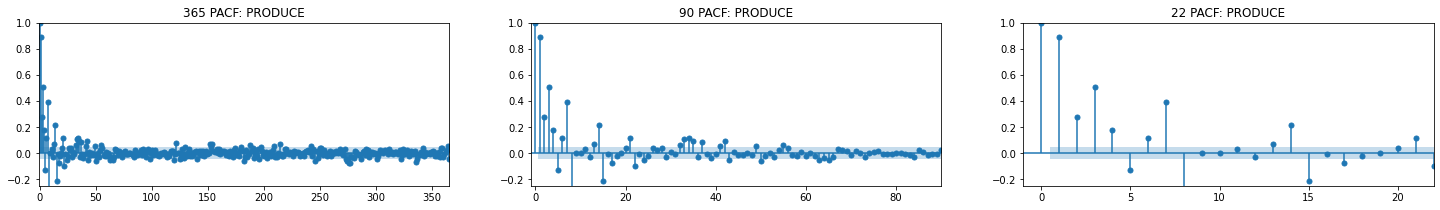

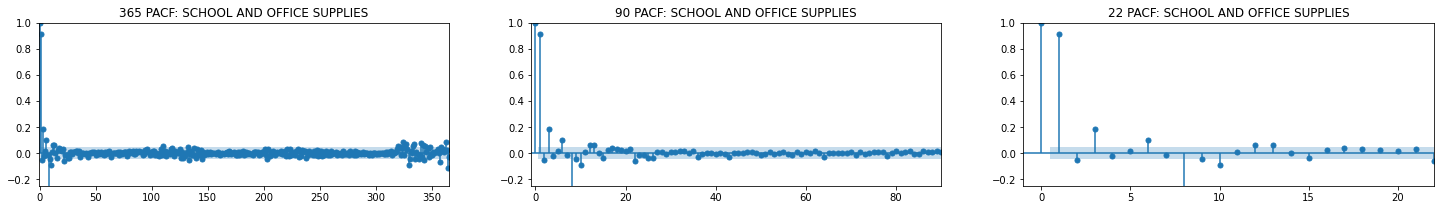

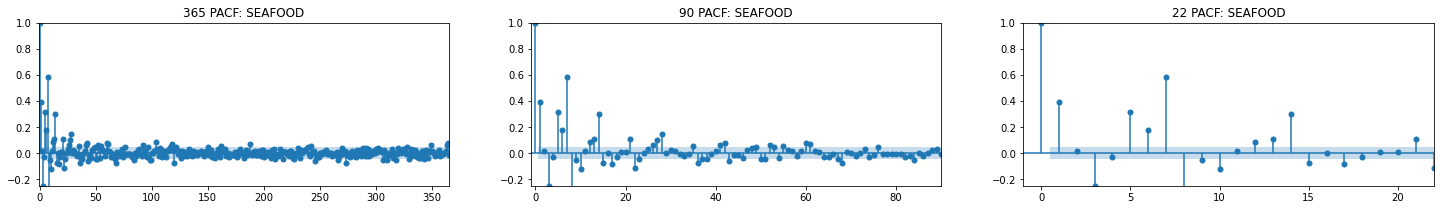

In [41]:
for num, i in enumerate(family_unique):
    fig, ax = plt.subplots(1,3,figsize=(25,3))
    temp = sales_mean[(sales_mean.family == i)]
    sm.graphics.tsa.plot_pacf(temp.sales, lags=365, ax=ax[0], title = "365 PACF: " + i, method="ywm")
    sm.graphics.tsa.plot_pacf(temp.sales, lags=365, ax=ax[1], title = "90 PACF: " + i, method="ywm")
    sm.graphics.tsa.plot_pacf(temp.sales, lags=365, ax=ax[2], title = "22 PACF: " + i,method="ywm")
    ax[0].set(xlim=[-1,365], ylim=[-0.25,1])
    ax[1].set(xlim=[-1,90], ylim=[-0.25,1])
    ax[2].set(xlim=[-1,22], ylim=[-0.25,1])

In [42]:
sales_plus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
 5   city         object        
 6   state        object        
 7   type         object        
 8   cluster      int64         
 9   promo_day    int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), object(4)
memory usage: 240.4+ MB


In [43]:
sales_plus["store_nbr"] = sales_plus["store_nbr"].astype(object)

In [44]:
sales_plus.head()

date store_nbr      family  sales  onpromotion   city      state type  \
0 2013-01-01         1  AUTOMOTIVE    0.0            0  Quito  Pichincha    D   
1 2013-01-01         1   BABY CARE    0.0            0  Quito  Pichincha    D   
2 2013-01-01         1      BEAUTY    0.0            0  Quito  Pichincha    D   
3 2013-01-01         1   BEVERAGES    0.0            0  Quito  Pichincha    D   
4 2013-01-01         1       BOOKS    0.0            0  Quito  Pichincha    D   

   cluster  promo_day  
0       13          0  
1       13          0  
2       13          0  
3       13          0  
4       13          0

In [45]:
stf_mean = pd.DataFrame(sales_plus.groupby(["store_nbr","family"]).sales.mean())
stf_mean.reset_index()

store_nbr                      family        sales
0             1                  AUTOMOTIVE     3.251188
1             1                   BABY CARE     0.000000
2             1                      BEAUTY     2.408551
3             1                   BEVERAGES  1587.748812
4             1                       BOOKS     0.125297
...         ...                         ...          ...
1777         54                     POULTRY    52.784924
1778         54              PREPARED FOODS    61.217340
1779         54                     PRODUCE   354.026315
1780         54  SCHOOL AND OFFICE SUPPLIES     0.607482
1781         54                     SEAFOOD     1.744656

[1782 rows x 3 columns]

In [46]:
stf_mean.rename(columns={"sales":"sales_mean"}, inplace=True)
stf_mean.reset_index()

store_nbr                      family   sales_mean
0             1                  AUTOMOTIVE     3.251188
1             1                   BABY CARE     0.000000
2             1                      BEAUTY     2.408551
3             1                   BEVERAGES  1587.748812
4             1                       BOOKS     0.125297
...         ...                         ...          ...
1777         54                     POULTRY    52.784924
1778         54              PREPARED FOODS    61.217340
1779         54                     PRODUCE   354.026315
1780         54  SCHOOL AND OFFICE SUPPLIES     0.607482
1781         54                     SEAFOOD     1.744656

[1782 rows x 3 columns]

In [47]:
stf_std = pd.DataFrame(sales_plus.groupby(["store_nbr", "family"]).sales.std())
stf_std.reset_index()

store_nbr                      family       sales
0             1                  AUTOMOTIVE    2.759605
1             1                   BABY CARE    0.000000
2             1                      BEAUTY    1.898950
3             1                   BEVERAGES  726.870056
4             1                       BOOKS    0.536578
...         ...                         ...         ...
1777         54                     POULTRY   26.526857
1778         54              PREPARED FOODS   28.508794
1779         54                     PRODUCE  318.035699
1780         54  SCHOOL AND OFFICE SUPPLIES    2.966594
1781         54                     SEAFOOD    2.260277

[1782 rows x 3 columns]

In [48]:
stf_std.rename(columns={"sales":"sales_std"}, inplace=True)
stf_std.reset_index()

store_nbr                      family   sales_std
0             1                  AUTOMOTIVE    2.759605
1             1                   BABY CARE    0.000000
2             1                      BEAUTY    1.898950
3             1                   BEVERAGES  726.870056
4             1                       BOOKS    0.536578
...         ...                         ...         ...
1777         54                     POULTRY   26.526857
1778         54              PREPARED FOODS   28.508794
1779         54                     PRODUCE  318.035699
1780         54  SCHOOL AND OFFICE SUPPLIES    2.966594
1781         54                     SEAFOOD    2.260277

[1782 rows x 3 columns]

In [49]:
stf_stats=pd.merge(stf_mean, stf_std, on=["store_nbr", "family"])
stf_stats

sales_mean   sales_std
store_nbr family                                             
1         AUTOMOTIVE                     3.251188    2.759605
          BABY CARE                      0.000000    0.000000
          BEAUTY                         2.408551    1.898950
          BEVERAGES                   1587.748812  726.870056
          BOOKS                          0.125297    0.536578
...                                           ...         ...
54        POULTRY                       52.784924   26.526857
          PREPARED FOODS                61.217340   28.508794
          PRODUCE                      354.026315  318.035699
          SCHOOL AND OFFICE SUPPLIES     0.607482    2.966594
          SEAFOOD                        1.744656    2.260277

[1782 rows x 2 columns]

In [50]:
stf_stats.reset_index()

store_nbr                      family   sales_mean   sales_std
0             1                  AUTOMOTIVE     3.251188    2.759605
1             1                   BABY CARE     0.000000    0.000000
2             1                      BEAUTY     2.408551    1.898950
3             1                   BEVERAGES  1587.748812  726.870056
4             1                       BOOKS     0.125297    0.536578
...         ...                         ...          ...         ...
1777         54                     POULTRY    52.784924   26.526857
1778         54              PREPARED FOODS    61.217340   28.508794
1779         54                     PRODUCE   354.026315  318.035699
1780         54  SCHOOL AND OFFICE SUPPLIES     0.607482    2.966594
1781         54                     SEAFOOD     1.744656    2.260277

[1782 rows x 4 columns]

In [51]:
sales_out = pd.merge(sales_plus, stf_stats, on=["store_nbr", "family"])
sales_out

date store_nbr      family      sales  onpromotion   city  \
0       2013-01-01         1  AUTOMOTIVE   0.000000            0  Quito   
1       2013-01-02         1  AUTOMOTIVE   2.000000            0  Quito   
2       2013-01-03         1  AUTOMOTIVE   3.000000            0  Quito   
3       2013-01-04         1  AUTOMOTIVE   3.000000            0  Quito   
4       2013-01-05         1  AUTOMOTIVE   5.000000            0  Quito   
...            ...       ...         ...        ...          ...    ...   
3000883 2017-08-11         9     SEAFOOD  23.831000            0  Quito   
3000884 2017-08-12         9     SEAFOOD  16.859001            4  Quito   
3000885 2017-08-13         9     SEAFOOD  20.000000            0  Quito   
3000886 2017-08-14         9     SEAFOOD  17.000000            0  Quito   
3000887 2017-08-15         9     SEAFOOD  16.000000            0  Quito   

             state type  cluster  promo_day  sales_mean  sales_std  
0        Pichincha    D       13          0    3.251188   2.759605  
1        Pichincha    D       13          0    3.251188   2.759605  
2        Pichincha    D       13          0    3.251188   2.759605  
3        Pichincha    D       13          0    3.251188   2.759605  
4        Pichincha    D       13          0    3.251188   2.759605  
...            ...  ...      ...        ...         ...        ...  
3000883  Pichincha    B        6          0   16.884394   9.379034  
3000884  Pichincha    B        6          1   16.884394   9.379034  
3000885  Pichincha    B        6          0   16.884394   9.379034  
3000886  Pichincha    B        6          0   16.884394   9.379034  
3000887  Pichincha    B        6          0   16.884394   9.379034  

[3000888 rows x 12 columns]

In [52]:
sales_out["sales_z"] = (sales_out["sales"] - sales_out["sales_mean"]) / sales_out["sales_std"]
sales_out

date store_nbr      family      sales  onpromotion   city  \
0       2013-01-01         1  AUTOMOTIVE   0.000000            0  Quito   
1       2013-01-02         1  AUTOMOTIVE   2.000000            0  Quito   
2       2013-01-03         1  AUTOMOTIVE   3.000000            0  Quito   
3       2013-01-04         1  AUTOMOTIVE   3.000000            0  Quito   
4       2013-01-05         1  AUTOMOTIVE   5.000000            0  Quito   
...            ...       ...         ...        ...          ...    ...   
3000883 2017-08-11         9     SEAFOOD  23.831000            0  Quito   
3000884 2017-08-12         9     SEAFOOD  16.859001            4  Quito   
3000885 2017-08-13         9     SEAFOOD  20.000000            0  Quito   
3000886 2017-08-14         9     SEAFOOD  17.000000            0  Quito   
3000887 2017-08-15         9     SEAFOOD  16.000000            0  Quito   

             state type  cluster  promo_day  sales_mean  sales_std   sales_z  
0        Pichincha    D       13          0    3.251188   2.759605 -1.178135  
1        Pichincha    D       13          0    3.251188   2.759605 -0.453394  
2        Pichincha    D       13          0    3.251188   2.759605 -0.091023  
3        Pichincha    D       13          0    3.251188   2.759605 -0.091023  
4        Pichincha    D       13          0    3.251188   2.759605  0.633718  
...            ...  ...      ...        ...         ...        ...       ...  
3000883  Pichincha    B        6          0   16.884394   9.379034  0.740653  
3000884  Pichincha    B        6          1   16.884394   9.379034 -0.002707  
3000885  Pichincha    B        6          0   16.884394   9.379034  0.332188  
3000886  Pichincha    B        6          0   16.884394   9.379034  0.012326  
3000887  Pichincha    B        6          0   16.884394   9.379034 -0.094295  

[3000888 rows x 13 columns]

In [53]:
sales_outliers = sales_out[(sales_out.sales_z > 3) | (sales_out.sales_z < -3)]
sales_outliers

date store_nbr      family   sales  onpromotion   city  \
136     2013-05-17         1  AUTOMOTIVE  12.000            0  Quito   
213     2013-08-02         1  AUTOMOTIVE  12.000            0  Quito   
224     2013-08-13         1  AUTOMOTIVE  14.000            0  Quito   
398     2014-02-04         1  AUTOMOTIVE  14.000            0  Quito   
527     2014-06-13         1  AUTOMOTIVE  12.000            0  Quito   
...            ...       ...         ...     ...          ...    ...   
3000389 2016-04-03         9     SEAFOOD  52.138            0  Quito   
3000508 2016-07-31         9     SEAFOOD  48.562            1  Quito   
3000571 2016-10-02         9     SEAFOOD  52.000            0  Quito   
3000781 2017-05-01         9     SEAFOOD  54.162            0  Quito   
3000815 2017-06-04         9     SEAFOOD  47.134            0  Quito   

             state type  cluster  promo_day  sales_mean  sales_std   sales_z  
136      Pichincha    D       13          0    3.251188   2.759605  3.170314  
213      Pichincha    D       13          0    3.251188   2.759605  3.170314  
224      Pichincha    D       13          0    3.251188   2.759605  3.895055  
398      Pichincha    D       13          0    3.251188   2.759605  3.895055  
527      Pichincha    D       13          0    3.251188   2.759605  3.170314  
...            ...  ...      ...        ...         ...        ...       ...  
3000389  Pichincha    B        6          0   16.884394   9.379034  3.758767  
3000508  Pichincha    B        6          1   16.884394   9.379034  3.377491  
3000571  Pichincha    B        6          0   16.884394   9.379034  3.744053  
3000781  Pichincha    B        6          0   16.884394   9.379034  3.974568  
3000815  Pichincha    B        6          0   16.884394   9.379034  3.225237  

[36274 rows x 13 columns]

In [54]:
sales_out_m = pd.pivot_table(sales_outliers, index = ["family"], values=["date"], aggfunc=len)
sales_out_m

date
family                          
AUTOMOTIVE                  1067
BABY CARE                   1673
BEAUTY                      1376
BEVERAGES                    648
BOOKS                       1017
BREAD/BAKERY                1070
CELEBRATION                 1051
CLEANING                    1010
DAIRY                        570
DELI                         742
EGGS                        1172
FROZEN FOODS                1598
GROCERY I                   1048
GROCERY II                  1335
HARDWARE                    1560
HOME AND KITCHEN I          1148
HOME AND KITCHEN II         1176
HOME APPLIANCES             1746
HOME CARE                    330
LADIESWEAR                  1182
LAWN AND GARDEN              788
LINGERIE                    1320
LIQUOR,WINE,BEER            1391
MAGAZINES                   1595
MEATS                        925
PERSONAL CARE                919
PET SUPPLIES                1383
PLAYERS AND ELECTRONICS     1132
POULTRY                      742
PREPARED FOODS               709
PRODUCE                      283
SCHOOL AND OFFICE SUPPLIES  1530
SEAFOOD                     1038

In [55]:
sales_stable

date  store_nbr                      family     sales  \
0       2013-01-01          1                  AUTOMOTIVE     0.000   
1       2013-01-01          1                   BABY CARE     0.000   
2       2013-01-01          1                      BEAUTY     0.000   
3       2013-01-01          1                   BEVERAGES     0.000   
4       2013-01-01          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3000883 2017-08-15          9                     POULTRY   438.133   
3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion   city      state type  cluster  promo_day  
0                  0  Quito  Pichincha    D       13          0  
1                  0  Quito  Pichincha    D       13          0  
2                  0  Quito  Pichincha    D       13          0  
3                  0  Quito  Pichincha    D       13          0  
4                  0  Quito  Pichincha    D       13          0  
...              ...    ...        ...  ...      ...        ...  
3000883            0  Quito  Pichincha    B        6          0  
3000884            1  Quito  Pichincha    B        6          1  
3000885          148  Quito  Pichincha    B        6          1  
3000886            8  Quito  Pichincha    B        6          1  
3000887            0  Quito  Pichincha    B        6          0  

[2334024 rows x 10 columns]

In [56]:
total_comp = pd.DataFrame(sales_stable.groupby("date").sales.sum())
rangecal = pd.date_range(sales_stable["date"].min(), sales_stable["date"].max())
total_comp = total_comp.reindex(rangecal).fillna(0.0).rename_axis("date").reset_index()

In [57]:
total_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1688 non-null   datetime64[ns]
 1   sales   1688 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.5 KB


In [58]:
total_comp = total_comp.set_index("date")
total_comp

sales
date                     
2013-01-01       0.000000
2013-01-02  466204.570948
2013-01-03  336313.337110
2013-01-04  330094.100091
2013-01-05  446707.397204
...                   ...
2017-08-11  655199.578022
2017-08-12  640582.959189
2017-08-13  704205.383454
2017-08-14  625006.872959
2017-08-15  621515.536964

[1688 rows x 1 columns]

In [59]:
pd.options.display.float_format = "{:,.2f}".format

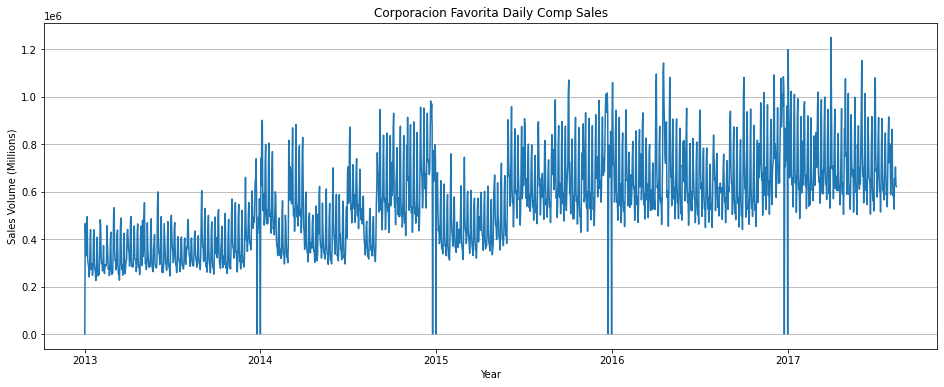

In [60]:
plt.figure(figsize=(16,6))
plt.title("Corporacion Favorita Daily Comp Sales")
plt.xlabel("Year")
plt.ylabel("Sales Volume (Millions)")
plt.grid(axis="y")
ax = sns.lineplot(data=total_comp,legend=False)